In [ ]:
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

dataset_path = "/content/drive/MyDrive/UCI_HAR_Dataset"

Mounted at /content/drive


# DataSet Creation and Analysis

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn

In [ ]:
# get feature names from the file features.txt
features = list()
with open('/content/drive/MyDrive/UCI_HAR_Dataset/features.txt') as f:
    features = [line.split()[1] for line in f.readlines()]

print('No of Features: {}'.format(len(features)))

No of Features: 561


In [ ]:
seen = set()
uniq_features = []
for idx, x in enumerate(features):
    if x not in seen:
        uniq_features.append(x)
        seen.add(x)
    elif x + 'n' not in seen:
        uniq_features.append(x + 'n')
        seen.add(x + 'n')
    else:
        uniq_features.append(x + 'nn')
        seen.add(x + 'nn')
len(uniq_features)

561

Train Dataset

In [ ]:
import pandas as pd

# get the data from txt files to pandas dataframe
X_train = pd.read_csv(
    '/content/drive/MyDrive/UCI_HAR_Dataset/train/X_train.txt',
    sep='\s+',              # instead of delim_whitespace=True
    header=None,
    names=uniq_features
)

# add subject column to the dataframe
subjects_train = pd.read_csv(
    '/content/drive/MyDrive/UCI_HAR_Dataset/train/subject_train.txt',
    header=None
).squeeze("columns")        # replaces squeeze=True

X_train['subject'] = subjects_train

# load y_train
y_train = pd.read_csv(
    '/content/drive/MyDrive/UCI_HAR_Dataset/train/y_train.txt',
    header=None,
    names=['Activity']
).squeeze("columns")

# map activity labels to human-readable names
y_train_labels = y_train.map({
    1: 'WALKING',
    2: 'WALKING_UPSTAIRS',
    3: 'WALKING_DOWNSTAIRS',
    4: 'SITTING',
    5: 'STANDING',
    6: 'LAYING'
})

# put all columns in a single dataframe
train = X_train.copy()
train['Activity'] = y_train
train['ActivityName'] = y_train_labels

print(train.shape)


<>:6: SyntaxWarning: invalid escape sequence '\s'
<>:6: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipython-input-661308084.py:6: SyntaxWarning: invalid escape sequence '\s'
  sep='\s+',              # instead of delim_whitespace=True


(7352, 564)


Test Set

In [ ]:
import pandas as pd

# get the data from txt files to pandas dataframe
X_test = pd.read_csv(
    '/content/drive/MyDrive/UCI_HAR_Dataset/test/X_test.txt',
    sep='\s+',              # instead of delim_whitespace=True
    header=None,
    names=uniq_features
)

# add subject column to the dataframe
subjects_test = pd.read_csv(
    '/content/drive/MyDrive/UCI_HAR_Dataset/test/subject_test.txt',
    header=None
).squeeze("columns")        # replaces squeeze=True

X_test['subject'] = subjects_test

# get y labels from the txt file
y_test = pd.read_csv(
    '/content/drive/MyDrive/UCI_HAR_Dataset/test/y_test.txt',
    header=None,
    names=['Activity']
).squeeze("columns")

# map activity labels to human-readable names
y_test_labels = y_test.map({
    1: 'WALKING',
    2: 'WALKING_UPSTAIRS',
    3: 'WALKING_DOWNSTAIRS',
    4: 'SITTING',
    5: 'STANDING',
    6: 'LAYING'
})

# put all columns in a single dataframe
test = X_test.copy()
test['Activity'] = y_test
test['ActivityName'] = y_test_labels

print(test.shape)


<>:6: SyntaxWarning: invalid escape sequence '\s'
<>:6: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipython-input-3925408283.py:6: SyntaxWarning: invalid escape sequence '\s'
  sep='\s+',              # instead of delim_whitespace=True


(2947, 564)


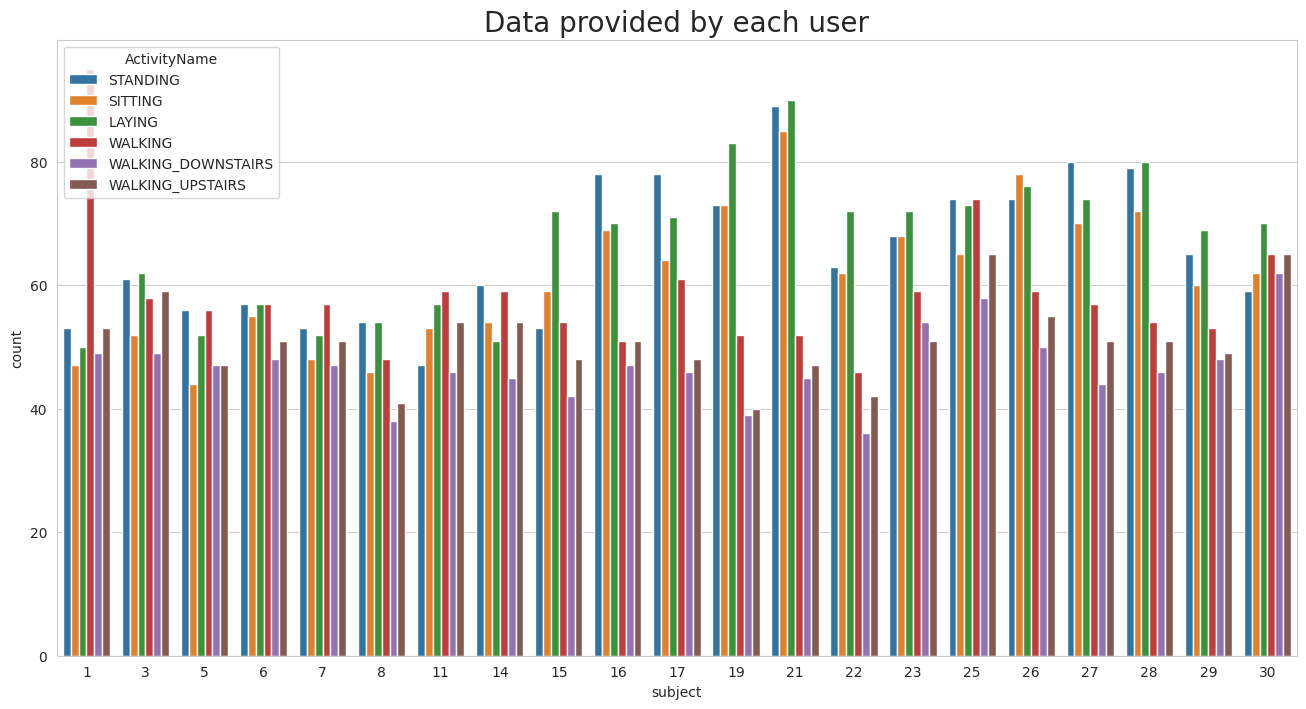

In [ ]:
sns.set_style('whitegrid')
plt.rcParams['font.family'] = 'Dejavu Sans'

plt.figure(figsize=(16,8))
plt.title('Data provided by each user', fontsize=20)
sns.countplot(x='subject',hue='ActivityName', data = train)
plt.show()

In [ ]:
columns = train.columns

# Removing '()' from column names
columns = columns.str.replace('[()]','')s
columns = columns.str.replace('[-]', '')
columns = columns.str.replace('[,]','')

train.columns = columns
test.columns = columns

test.columns

Index(['tBodyAcc-mean()-X', 'tBodyAcc-mean()-Y', 'tBodyAcc-mean()-Z',
       'tBodyAcc-std()-X', 'tBodyAcc-std()-Y', 'tBodyAcc-std()-Z',
       'tBodyAcc-mad()-X', 'tBodyAcc-mad()-Y', 'tBodyAcc-mad()-Z',
       'tBodyAcc-max()-X',
       ...
       'angle(tBodyAccMean,gravity)', 'angle(tBodyAccJerkMean),gravityMean)',
       'angle(tBodyGyroMean,gravityMean)',
       'angle(tBodyGyroJerkMean,gravityMean)', 'angle(X,gravityMean)',
       'angle(Y,gravityMean)', 'angle(Z,gravityMean)', 'subject', 'Activity',
       'ActivityName'],
      dtype='object', length=564)

In [ ]:
import os

os.makedirs(dataset_path + '/data', exist_ok=True)

train.to_csv(dataset_path + '/data/train.csv', index=False)
test.to_csv(dataset_path + '/data/test.csv', index=False)


# Train an MLP model on extracted features

In [ ]:
import sklearn
from sklearn import metrics

In [ ]:
# Import different classifiers
from sklearn import svm
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, AdaBoostClassifier

**Define a class model and train function**

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

class FlexibleMLP(torch.nn.Module):
    def __init__(self, input_dim, hidden_dims, output_dim):
        super(FlexibleMLP, self).__init__()
        layers = []
        prev_dim = input_dim
        for hdim in hidden_dims:
            layers.append(torch.nn.Linear(prev_dim, hdim))
            layers.append(torch.nn.ReLU())
            prev_dim = hdim
        self.feature_extractor = torch.nn.Sequential(*layers)
        self.classifier = torch.nn.Linear(prev_dim, output_dim)

    def forward(self, x):
        feats = self.feature_extractor(x)
        out = self.classifier(feats)
        return out

    # Add this method for embedding extraction
    def hidden_forward(self, x):
        return self.feature_extractor(x)




# ---- Train model ----
def train_model(X_train, y_train, model,
                X_test=None, y_test=None,
                epochs=100, lr=0.01, batch_size=64):
    """
    Train a PyTorch model and optionally evaluate on a test set each epoch.

    Parameters:
        X_train, y_train: training data (numpy arrays)
        X_test, y_test: test data (numpy arrays), optional
        model: PyTorch nn.Module
        epochs: number of epochs
        lr: learning rate
        batch_size: batch size
    """
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=lr)

    # Convert data to tensors
    X_train = torch.FloatTensor(X_train)
    y_train = torch.LongTensor(y_train)
    train_dataset = TensorDataset(X_train, y_train)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    if X_test is not None and y_test is not None:
        X_test = torch.FloatTensor(X_test)
        y_test = torch.LongTensor(y_test)

    for epoch in range(epochs):
        model.train()
        total_loss = 0
        correct = 0
        for xb, yb in train_loader:
            optimizer.zero_grad()
            out = model(xb)
            loss = criterion(out, yb)
            loss.backward()
            optimizer.step()

            total_loss += loss.item() * xb.size(0)
            correct += (out.argmax(dim=1) == yb).sum().item()

        train_loss = total_loss / len(train_loader.dataset)
        train_acc = correct / len(train_loader.dataset)

        if X_test is not None and y_test is not None:
            model.eval()
            with torch.no_grad():
                out_test = model(X_test)
                test_loss = criterion(out_test, y_test).item()
                test_acc = (out_test.argmax(dim=1) == y_test).float().mean().item()
                '''
            print(f"Epoch {epoch+1}: "
                  f"Train Loss={train_loss:.4f}, Train Acc={train_acc:.4f} | "
                  "Test Loss={test_loss:.4f}, Test Acc={test_acc:.4f}")
        else:
            print(f"Epoch {epoch+1}: Train Loss={train_loss:.4f}, Train Acc={train_acc:.4f}")
            '''
    if X_test is not None and y_test is not None:
       print(f"Train Loss={train_loss:.4f}, Train Acc={train_acc:.4f} | Test Loss={test_loss:.4f}, Test Acc={test_acc:.4f}")
    return model




**Load the train and test data, merge them, specify the test subjects, and train the model**

In [ ]:
import os
import torch
import pickle
import numpy as np
import pandas as pd
import sklearn
from sklearn.preprocessing import LabelEncoder
from scipy.stats import entropy  # <-- for prediction entropy

# ---------------------------
# Load full dataset (train + test merged)
# ---------------------------
def read_data(files, exclude_subjects=None):
    # Merge multiple csv files
    data = pd.concat([pd.read_csv(f) for f in files], ignore_index=True)
    data = sklearn.utils.shuffle(data)

    if exclude_subjects is not None:
        data = data[~data["subject"].isin(exclude_subjects)]

    X_data = data.drop(['subject', 'Activity', 'ActivityName'], axis=1)
    y_data = data.ActivityName
    subjects = data["subject"].values

    return np.array(X_data), np.array(y_data), subjects


# ---------------------------
# Merge train + test
# ---------------------------
all_X, all_y, all_subjects = read_data([
    dataset_path + '/data/train.csv',
    dataset_path + '/data/test.csv'
])

print("All data:", all_X.shape, all_y.shape)

# ---------------------------
# Choose test subjects
# ---------------------------
test_subjects = [10]   # tough test subject set = [9, 10, 14, 16]
print("Selected test subjects:", test_subjects)

# Split into train/test based on subject IDs
train_mask = ~np.isin(all_subjects, test_subjects)
test_mask  = np.isin(all_subjects, test_subjects)

train_X, train_y = all_X[train_mask], all_y[train_mask]
test_X, test_y   = all_X[test_mask], all_y[test_mask]

print("Train :", train_X.shape, train_y.shape)
print("Test  :", test_X.shape, test_y.shape)

# ---------------------------
# Encode labels to integers
# ---------------------------
label_encoder = LabelEncoder()
train_y_encoded = label_encoder.fit_transform(train_y)
test_y_encoded  = label_encoder.transform(test_y)

# Convert X to float32 (for PyTorch compatibility)
train_X = train_X.astype("float32")
test_X  = test_X.astype("float32")

# ---------------------------
# Model setup
# ---------------------------
input_dim = train_X.shape[1]
hidden_dims = [100, 100, 100]
output_dim = len(np.unique(train_y))

common_model = FlexibleMLP(input_dim, hidden_dims, output_dim)

# Train common model (assuming you have train_model() defined elsewhere)
common_model = train_model(
    train_X, train_y_encoded,
    common_model,
    test_X, test_y_encoded,
    epochs=100, lr=0.01, batch_size=64
)

# ---------------------------
# Save model + label encoder
# ---------------------------
model_file = os.path.join(dataset_path, "models", "common_mlp.pt")
torch.save(common_model.state_dict(), model_file)

le_file = os.path.join(dataset_path, "models", "label_encoder.pkl")
with open(le_file, "wb") as f:
    pickle.dump(label_encoder, f)

#print(f" Model saved to {model_file}")
#print(f" Label encoder saved to {le_file}")


# =======================================================
#  Entropy evaluation for general model
# =======================================================
common_model.eval()
with torch.no_grad():
    logits = common_model(torch.from_numpy(test_X))
    probs = torch.softmax(logits, dim=1).cpu().numpy()

# Per-sample entropy
per_sample_entropy = entropy(probs.T)  # shape (n_samples,)

# Average entropy overall
avg_entropy = np.mean(per_sample_entropy)

# Average entropy per class
class_entropies = {}
for cls in np.unique(test_y_encoded):
    cls_mask = test_y_encoded == cls
    class_entropies[label_encoder.inverse_transform([cls])[0]] = np.mean(per_sample_entropy[cls_mask])

print("\n Prediction Entropy (General Model)")
print("Per-sample entropy (first 10):", per_sample_entropy[:10])
print("Average entropy overall:", avg_entropy)
print("Average entropy per class:", class_entropies)


All data: (10299, 561) (10299,)
Selected test subjects: [10]
Train : (10005, 561) (10005,)
Test  : (294, 561) (294,)
Train Loss=0.0496, Train Acc=0.9826 | Test Loss=0.3074, Test Acc=0.8537

 Prediction Entropy (General Model)
Per-sample entropy (first 10): [1.1006866e-04 5.0554629e-02 6.6941440e-01 7.4720848e-04 1.3369434e-01
 1.5835803e-04 3.5905361e-02 6.6004968e-01 1.0832670e-01 7.1546346e-02]
Average entropy overall: 0.16381133
Average entropy per class: {'LAYING': np.float32(0.2130118), 'SITTING': np.float32(0.20250928), 'STANDING': np.float32(0.22455402), 'WALKING': np.float32(0.04745704), 'WALKING_DOWNSTAIRS': np.float32(0.00078153005), 'WALKING_UPSTAIRS': np.float32(0.26478827)}


**Fine-tune the general model on each specific train subject's data, then evaluate on the test subject's data**

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
from sklearn.metrics import accuracy_score
from scipy.stats import entropy

# ---------------------------
# Config
# ---------------------------
batch_size = 16
epochs = 30
lr = 0.005
num_unfrozen_layers = 1   # last layers to unfreeze
test_subject_id = test_subjects[0]   # chosen test subject

# ---------------------------
# Split dataset into train/test by subject IDs
# ---------------------------
train_mask = all_subjects != test_subject_id
test_mask  = all_subjects == test_subject_id

train_X, train_y = all_X[train_mask], all_y[train_mask]
train_subjects   = all_subjects[train_mask]

test_X, test_y = all_X[test_mask], all_y[test_mask]

train_y_encoded = label_encoder.transform(train_y)
test_y_encoded  = label_encoder.transform(test_y)

input_dim = train_X.shape[1]
hidden_dims = [100, 100, 100]
output_dim = len(label_encoder.classes_)

# ---------------------------
# Dictionary to save models
# ---------------------------
personalized_models = {"general": common_model.state_dict()}  # store general model weights
subject_accs = {}
subject_entropies = {}

# ---------------------------
# Fine-tune per train subject
# ---------------------------
unique_train_subjects = np.unique(train_subjects)

for subj in unique_train_subjects:
    print(f" Fine-tuning on Train Subject {subj}")

    # Select data for this train subject
    subj_mask = train_subjects == subj
    subj_X = train_X[subj_mask].astype("float32")
    subj_y = train_y_encoded[subj_mask]

    dataset = TensorDataset(torch.from_numpy(subj_X), torch.from_numpy(subj_y))
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    # Clone common model
    personal_model = FlexibleMLP(input_dim, hidden_dims, output_dim)
    personal_model.load_state_dict(common_model.state_dict())

    # ---------------------------
    # Freeze all layers first
    for param in personal_model.parameters():
        param.requires_grad = False

    # Unfreeze last N layers of feature_extractor
    feature_layers = list(personal_model.feature_extractor.children())
    if num_unfrozen_layers > len(feature_layers):
        raise ValueError(f"num_unfrozen_layers ({num_unfrozen_layers}) exceeds number of layers in feature_extractor ({len(feature_layers)})")
    for layer in feature_layers[-num_unfrozen_layers:]:
        for param in layer.parameters():
            param.requires_grad = True

    # Also unfreeze classifier
    for param in personal_model.classifier.parameters():
        param.requires_grad = True

    personal_model.train()
    optimizer = optim.Adam(filter(lambda p: p.requires_grad, personal_model.parameters()), lr=lr)
    criterion = nn.CrossEntropyLoss()

    # Training loop
    for epoch in range(epochs):
        for batch_X, batch_y in loader:
            batch_X = batch_X.float()
            batch_y = batch_y.long()
            optimizer.zero_grad()
            logits = personal_model(batch_X)
            loss = criterion(logits, batch_y)
            loss.backward()
            optimizer.step()

    # Save only classifier layer for this subject
    personalized_models[subj] = {
        "weight": personal_model.classifier.weight.clone(),
        "bias": personal_model.classifier.bias.clone()
    }

    # ---------------------------
    # Evaluate on test subject + per-sample entropy
    # ---------------------------
    model_eval = FlexibleMLP(input_dim, hidden_dims, output_dim)
    model_eval.load_state_dict(common_model.state_dict())  # backbone + init classifier
    with torch.no_grad():
        model_eval.classifier.weight.copy_(personalized_models[subj]["weight"])
        model_eval.classifier.bias.copy_(personalized_models[subj]["bias"])

    X_test_tensor = torch.from_numpy(test_X.astype("float32"))
    y_test_encoded = test_y_encoded

    model_eval.eval()
    with torch.no_grad():
        logits = model_eval(X_test_tensor)
        probs = torch.softmax(logits, dim=1).cpu().numpy()
        preds = probs.argmax(axis=1)

    acc = accuracy_score(y_test_encoded, preds) * 100
    subject_accs[subj] = acc

    # Per-sample entropy (prediction uncertainty)
    per_sample_entropy = entropy(probs.T)  # entropy across classes for each sample
    avg_entropy = np.mean(per_sample_entropy)
    subject_entropies[subj] = {
        "per_sample_entropy": per_sample_entropy,
        "avg_entropy": avg_entropy
    }

    print(f" Train Subj {subj} → Test Subj {test_subject_id}: {acc:.2f}% (n={len(y_test_encoded)})")
    print(f"    Avg Prediction Entropy: {avg_entropy:.4f}\n")

# ---------------------------
# Summary
# ---------------------------
print("\n Accuracy Results:", subject_accs)
print("\n Avg Prediction Entropies:", {k:v['avg_entropy'] for k,v in subject_entropies.items()})


 Fine-tuning on Train Subject 1
 Train Subj 1 → Test Subj 10: 87.76% (n=294)
    Avg Prediction Entropy: 0.1295

 Fine-tuning on Train Subject 2
 Train Subj 2 → Test Subj 10: 85.37% (n=294)
    Avg Prediction Entropy: 0.1060

 Fine-tuning on Train Subject 3
 Train Subj 3 → Test Subj 10: 86.73% (n=294)
    Avg Prediction Entropy: 0.0871

 Fine-tuning on Train Subject 4
 Train Subj 4 → Test Subj 10: 83.67% (n=294)
    Avg Prediction Entropy: 0.1141

 Fine-tuning on Train Subject 5
 Train Subj 5 → Test Subj 10: 84.69% (n=294)
    Avg Prediction Entropy: 0.1002

 Fine-tuning on Train Subject 6
 Train Subj 6 → Test Subj 10: 89.12% (n=294)
    Avg Prediction Entropy: 0.0799

 Fine-tuning on Train Subject 7
 Train Subj 7 → Test Subj 10: 88.44% (n=294)
    Avg Prediction Entropy: 0.1336

 Fine-tuning on Train Subject 8
 Train Subj 8 → Test Subj 10: 79.59% (n=294)
    Avg Prediction Entropy: 0.1048

 Fine-tuning on Train Subject 9
 Train Subj 9 → Test Subj 10: 90.48% (n=294)
    Avg Prediction 

In [ ]:
# ---------------------------
# Inspect a single test sample
# ---------------------------
sample_idx = 7  # <-- change to any index you want
x_single = torch.from_numpy(test_X[sample_idx].astype("float32")).unsqueeze(0)
y_true   = test_y_encoded[sample_idx]

print(f"\n🔍 Test Sample {sample_idx}")
print(f"   Ground Truth: {label_encoder.inverse_transform([y_true])[0]} (class {y_true})")

# ---- General Model ----
common_model.eval()
with torch.no_grad():
    logits = common_model(x_single)
    probs = torch.softmax(logits, dim=1).cpu().numpy().flatten()
    pred = probs.argmax()
    ent = entropy(probs)

print(f"   General Model → Pred: {label_encoder.inverse_transform([pred])[0]} (class {pred}), "
      f"Entropy={ent:.4f}")

# ---- Personalized Models ----
for subj in [s for s in personalized_models.keys() if s != "general"]:
    model_eval = FlexibleMLP(input_dim, hidden_dims, output_dim)
    model_eval.load_state_dict(common_model.state_dict())

    with torch.no_grad():
        model_eval.classifier.weight.copy_(personalized_models[subj]["weight"])
        model_eval.classifier.bias.copy_(personalized_models[subj]["bias"])

        model_eval.eval()
        logits = model_eval(x_single)
        probs = torch.softmax(logits, dim=1).cpu().numpy().flatten()
        pred = probs.argmax()
        ent = entropy(probs)

    print(f"   Personal Model {subj} → Pred: {label_encoder.inverse_transform([pred])[0]} (class {pred}), "
          f"Entropy={ent:.4f}")



🔍 Test Sample 7
   Ground Truth: STANDING (class 2)
   General Model → Pred: SITTING (class 1), Entropy=0.6600
   Personal Model 1 → Pred: STANDING (class 2), Entropy=0.5284
   Personal Model 2 → Pred: SITTING (class 1), Entropy=0.0476
   Personal Model 3 → Pred: SITTING (class 1), Entropy=0.1348
   Personal Model 4 → Pred: SITTING (class 1), Entropy=0.6780
   Personal Model 5 → Pred: STANDING (class 2), Entropy=0.0790
   Personal Model 6 → Pred: SITTING (class 1), Entropy=0.1815
   Personal Model 7 → Pred: STANDING (class 2), Entropy=0.6801
   Personal Model 8 → Pred: STANDING (class 2), Entropy=0.0209
   Personal Model 9 → Pred: SITTING (class 1), Entropy=0.4467
   Personal Model 11 → Pred: SITTING (class 1), Entropy=0.6129
   Personal Model 12 → Pred: SITTING (class 1), Entropy=0.0464
   Personal Model 13 → Pred: SITTING (class 1), Entropy=0.4739
   Personal Model 14 → Pred: SITTING (class 1), Entropy=0.2779
   Personal Model 15 → Pred: SITTING (class 1), Entropy=0.2953
   Personal

# **Domain Adaptation**

**Similarity between train subjects and a specific test subject**

In [ ]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from sklearn.metrics.pairwise import cosine_similarity, pairwise_distances, euclidean_distances

# ============================================================
# 1. Build DataFrame
# ============================================================
def make_df(X: np.ndarray, y, subjects_per_sample) -> pd.DataFrame:
    assert len(X) == len(y) == len(subjects_per_sample), (
        f"Length mismatch: X={len(X)}, y={len(y)}, subjects={len(subjects_per_sample)}"
    )
    n_features = X.shape[1]
    df = pd.DataFrame(X, columns=[f"f{i}" for i in range(n_features)])
    df["subject"] = np.asarray(subjects_per_sample)
    df["ActivityName"] = np.asarray(y)
    return df.reset_index(drop=True)

# ============================================================
# 2. Compute mean feature vectors (input-level)
# ============================================================
def compute_mean_feature_vectors(data, n_features, class_order=None):
    results = {}
    for subject_id, sub_df in data.groupby("subject"):
        subject_matrix = []
        activities = class_order if class_order else sorted(sub_df["ActivityName"].unique())
        for activity_name in activities:
            act_df = sub_df[sub_df["ActivityName"] == activity_name]
            if len(act_df) > 0:
                X = act_df.drop(["subject", "ActivityName"], axis=1).values
                mean_vec = X.mean(axis=0)
            else:
                mean_vec = np.zeros(n_features)
            subject_matrix.append(mean_vec)
        results[subject_id] = np.vstack(subject_matrix)
    return results

# ============================================================
# 3. FlexibleMLP model (for embeddings)
# ============================================================
class FlexibleMLP(nn.Module):
    def __init__(self, input_dim, hidden_dims, output_dim):
        super(FlexibleMLP, self).__init__()
        layers = []
        last_dim = input_dim
        for h in hidden_dims:
            layers.append(nn.Linear(last_dim, h))
            layers.append(nn.ReLU())
            last_dim = h
        self.feature_extractor = nn.Sequential(*layers)
        self.classifier = nn.Linear(last_dim, output_dim)

    def forward(self, x):
        hidden = self.feature_extractor(x)
        return self.classifier(hidden)

    def hidden_forward(self, x):
        return self.feature_extractor(x)

# ============================================================
# 4. Extract embeddings
# ============================================================
def extract_embeddings(model, X):
    with torch.no_grad():
        X_tensor = torch.from_numpy(X.astype("float32"))
        hidden_out = model.hidden_forward(X_tensor)
    return hidden_out.numpy()

def compute_mean_embeddings_from_arrays(X, y, subjects, model, n_features):
    df = pd.DataFrame(X, columns=[f"f{i}" for i in range(n_features)])
    df["subject"] = subjects
    df["ActivityName"] = y

    results = {}
    for subject_id, sub_df in df.groupby("subject"):
        subject_matrix = []
        for activity_name, act_df in sub_df.groupby("ActivityName"):
            X_sub = act_df.drop(["subject", "ActivityName"], axis=1).values
            embeddings = extract_embeddings(model, X_sub)
            mean_vec = embeddings.mean(axis=0)
            subject_matrix.append(mean_vec)
        results[subject_id] = np.vstack(subject_matrix)
    return results

# ============================================================
# 5. MAIN PIPELINE
# ============================================================
def compute_similar_subjects(train_X, train_y, train_subjects,
                             test_X, test_y, test_subjects,
                             test_subject_id,
                             input_dim=561, hidden_dims=[100,100,100], output_dim=6):
    # --- Build train/test DataFrames
    train_df = make_df(train_X, train_y, train_subjects)

    if len(test_subjects) != len(test_X):
        test_subjects_per_sample = np.repeat(test_subjects[0], len(test_X))
    else:
        test_subjects_per_sample = test_subjects
    test_df = make_df(test_X, test_y, test_subjects_per_sample)

    all_classes = sorted(train_df["ActivityName"].unique())

    # --- Input-level means
    train_input_means = compute_mean_feature_vectors(train_df, n_features=input_dim, class_order=all_classes)
    test_input_means  = compute_mean_feature_vectors(test_df,  n_features=input_dim, class_order=all_classes)

    # --- Embedding-level means
    common_model = FlexibleMLP(input_dim, hidden_dims, output_dim)
    common_model.eval()
    train_embed_means = compute_mean_embeddings_from_arrays(train_X, train_y, train_subjects, common_model, n_features=input_dim)
    test_embed_means  = compute_mean_embeddings_from_arrays(test_X, test_y, test_subjects_per_sample, common_model, n_features=input_dim)

    # --- Safety check
    if test_subject_id not in test_input_means or test_subject_id not in test_embed_means:
        raise ValueError(f"❌ Test subject {test_subject_id} not found in test set!")

    # ========================================================
    # Input-level similarities
    # ========================================================
    test_vec_input = test_input_means[test_subject_id].flatten().reshape(1, -1)

    cosine_sims_input, euclidean_dists_input = {}, {}
    for train_id, train_matrix in train_input_means.items():
        train_vec = train_matrix.flatten().reshape(1, -1)
        cosine_sims_input[train_id] = cosine_similarity(test_vec_input, train_vec)[0, 0]
        euclidean_dists_input[train_id] = pairwise_distances(test_vec_input, train_vec, metric="euclidean")[0, 0]

    similar_input_cosine   = [sid for sid, _ in sorted(cosine_sims_input.items(), key=lambda x: x[1], reverse=True)]
    similar_input_euclidean = [sid for sid, _ in sorted(euclidean_dists_input.items(), key=lambda x: x[1])]

    # ========================================================
    # Embedding-level similarities
    # ========================================================
    test_vec_embed = test_embed_means[test_subject_id].flatten().reshape(1, -1)

    cosine_sims_embed, euclidean_dists_embed = {}, {}
    for train_id, train_matrix in train_embed_means.items():
        train_vec = train_matrix.flatten().reshape(1, -1)
        cosine_sims_embed[train_id] = cosine_similarity(test_vec_embed, train_vec)[0, 0]
        euclidean_dists_embed[train_id] = euclidean_distances(test_vec_embed, train_vec)[0, 0]

    similar_embedding_cosine   = [sid for sid, _ in sorted(cosine_sims_embed.items(), key=lambda x: x[1], reverse=True)]
    similar_embedding_euclidean = [sid for sid, _ in sorted(euclidean_dists_embed.items(), key=lambda x: x[1])]

    return similar_input_cosine, similar_input_euclidean, similar_embedding_cosine, similar_embedding_euclidean

# ============================================================
# Example usage
# ============================================================
similar_input_cosine, similar_input_euclidean, similar_embedding_cosine, similar_embedding_euclidean = compute_similar_subjects(
    train_X, train_y, train_subjects,
    test_X, test_y, test_subjects,
    test_subject_id=test_subjects[0]
)

print("✅ Similar train subjects (Input Cosine):", similar_input_cosine[:5])
print("✅ Similar train subjects (Input Euclidean):", similar_input_euclidean[:5])
print("✅ Similar train subjects (Embedding Cosine):", similar_embedding_cosine[:5])
print("✅ Similar train subjects (Embedding Euclidean):", similar_embedding_euclidean[:5])


✅ Similar train subjects (Input Cosine): [17, 27, 24, 9, 18]
✅ Similar train subjects (Input Euclidean): [17, 27, 24, 9, 18]
✅ Similar train subjects (Embedding Cosine): [27, 17, 24, 18, 9]
✅ Similar train subjects (Embedding Euclidean): [27, 17, 24, 18, 9]


Assemble a model the best train subject collection for the subject test

In [ ]:
import torch
from sklearn.metrics import accuracy_score

def build_average_personalized_model(
    similar_train_subjects: list,
    personalized_models: dict,
    input_dim: int,
    hidden_dims: list,
    output_dim: int,
):
    """
    Build averaged personalized model from a set of training subjects.
    """
    if "general" not in personalized_models:
        raise KeyError("personalized_models must contain the 'general' snapshot.")
    for sid in similar_train_subjects:
        if sid not in personalized_models:
            raise KeyError(f"personalized_models has no classifier head for subject {sid}.")

    # Create backbone from general model
    model = FlexibleMLP(input_dim, hidden_dims, output_dim)
    general_sd = personalized_models["general"]
    backbone_sd = {k: v for k, v in general_sd.items() if k.startswith("feature_extractor.")}
    model.load_state_dict(backbone_sd, strict=False)

    # Average classifier heads
    weight_list, bias_list = [], []
    for sid in similar_train_subjects:
        head = personalized_models[sid]
        weight_list.append(head["weight"])
        bias_list.append(head["bias"])
    avg_weight = torch.stack(weight_list).mean(dim=0)
    avg_bias   = torch.stack(bias_list).mean(dim=0)

    with torch.no_grad():
        model.classifier.weight.copy_(avg_weight)
        model.classifier.bias.copy_(avg_bias)

    return model.float().cpu().eval()


def evaluate_model(model, X_test, y_test):
    X_test_tensor = torch.from_numpy(X_test.astype("float32"))
    with torch.no_grad():
        logits = model(X_test_tensor)
        preds = logits.argmax(dim=1).cpu().numpy()
    return accuracy_score(y_test, preds)


# ============================================================
# Greedy search for best subset of train subjects
# ============================================================
def find_best_similar_subjects(train_subject_ids, personalized_models,
                               test_X, test_y_encoded,
                               input_dim, hidden_dims, output_dim,
                               max_subset_size=5):
    best_subset = []
    best_acc = 0.0
    remaining = set(train_subject_ids)

    for step in range(max_subset_size):
        best_candidate, best_candidate_acc = None, 0.0

        for sid in remaining:
            candidate_subset = best_subset + [sid]
            model = build_average_personalized_model(
                candidate_subset, personalized_models,
                input_dim, hidden_dims, output_dim
            )
            acc = evaluate_model(model, test_X, test_y_encoded)
            if acc > best_candidate_acc:
                best_candidate_acc = acc
                best_candidate = sid

        if best_candidate is not None and best_candidate_acc > best_acc:
            best_subset.append(best_candidate)
            remaining.remove(best_candidate)
            best_acc = best_candidate_acc
            #print(f"Step {step+1}: added subject {best_candidate}, acc={best_acc:.2f}")
        else:
            break  # no improvement

    return best_subset, best_acc


# =========================
# Example usage
# =========================
available_train_subjects = [sid for sid in range(1, 30) if sid in personalized_models]
test_subject_id = test_subjects[0]  # choose a test subject

best_subset, best_acc = find_best_similar_subjects(
    train_subject_ids=available_train_subjects,
    personalized_models=personalized_models,
    test_X=test_X, test_y_encoded=test_y_encoded,
    input_dim=input_dim, hidden_dims=hidden_dims, output_dim=output_dim,
    max_subset_size=5
)

print(f"✅ Best subset for test subject {test_subject_id}: {best_subset}, acc={best_acc*100:.2f}%")


✅ Best subset for test subject 16: [10], acc=90.71%


Assemble a model from the most similar train subjects in terms of feature or embedding similarity

In [ ]:
import torch
from sklearn.metrics import accuracy_score

def build_average_personalized_model(
    similar_train_subjects: list,
    personalized_models: dict,
    input_dim: int,
    hidden_dims: list,
    output_dim: int,
):
    """
    Build a personalized model for a test subject by:
      1) Loading the backbone (feature_extractor) from the general model
      2) Averaging the personalized classifier layers of similar train subjects
    Returns a ready-to-infer CPU/float32 model in eval() mode.
    """
    if "general" not in personalized_models:
        raise KeyError("personalized_models must contain the 'general' snapshot.")
    for sid in similar_train_subjects:
        if sid not in personalized_models:
            raise KeyError(f"personalized_models has no classifier head for subject {sid}.")

    # ----- 1) Create fresh model and load backbone -----
    model = FlexibleMLP(input_dim, hidden_dims, output_dim)
    general_sd = personalized_models["general"]
    backbone_sd = {k: v for k, v in general_sd.items() if k.startswith("feature_extractor.")}
    model.load_state_dict(backbone_sd, strict=False)

    # ----- 2) Average classifier layers of similar subjects -----
    weight_list = []
    bias_list = []
    for sid in similar_train_subjects:
        head = personalized_models[sid]  # dict with 'weight' and 'bias'
        weight_list.append(head["weight"])
        bias_list.append(head["bias"])

    # Compute mean
    avg_weight = torch.stack(weight_list).mean(dim=0)
    avg_bias   = torch.stack(bias_list).mean(dim=0)

    # ----- 3) Attach averaged classifier to the model -----
    with torch.no_grad():
        model.classifier.weight.copy_(avg_weight)
        model.classifier.bias.copy_(avg_bias)

    # Set dtype/device and eval mode
    model = model.float().cpu().eval()
    return model


# =========================
# Example usage
# =========================
similar_train_subjects = similar_embedding_euclidean[:3]  # the train subjects to average
test_subject_id = test_subjects[0]

avg_model = build_average_personalized_model(
    similar_train_subjects=similar_train_subjects,
    personalized_models=personalized_models,
    input_dim=input_dim,
    hidden_dims=hidden_dims,
    output_dim=output_dim
)

print("✅ Built averaged personalized model for test subject", test_subject_id)

# ---------------------------
# Evaluate on test subject
# ---------------------------
X_test_tensor = torch.from_numpy(test_X.astype("float32"))

avg_model.eval()
with torch.no_grad():
    logits = avg_model(X_test_tensor)
    preds = logits.argmax(dim=1).cpu().numpy()

acc = accuracy_score(test_y_encoded, preds) * 100
print(f"✅ Accuracy of averaged model on test subject {test_subject_id}: {acc:.2f}% (n={len(test_y_encoded)})")


✅ Built averaged personalized model for test subject 16
✅ Accuracy of averaged model on test subject 16: 87.98% (n=366)


In [ ]:
import numpy as np
import torch
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score

results = {}
K = 1  # number of most similar subjects
all_test_subjects = np.unique(all_subjects)

for test_subject_id in all_test_subjects:
    print(f"\n================== Test Subject {test_subject_id} ==================")

    # ---------------------------
    # Split data for this LOSO round
    # ---------------------------
    train_mask = all_subjects != test_subject_id
    test_mask  = all_subjects == test_subject_id

    train_X, train_y = all_X[train_mask], all_y[train_mask]
    test_X, test_y   = all_X[test_mask], all_y[test_mask]
    train_subjects   = all_subjects[train_mask]

    # ---------------------------
    # Encode labels (fit only on train subjects)
    # ---------------------------
    label_encoder = LabelEncoder()
    train_y_encoded = label_encoder.fit_transform(train_y)
    test_y_encoded  = label_encoder.transform(test_y)

    train_X = train_X.astype("float32")
    test_X  = test_X.astype("float32")

    # ---------------------------
    # Train new general model for current LOSO split
    # ---------------------------
    input_dim = train_X.shape[1]
    hidden_dims = [100, 100, 100]
    output_dim = len(label_encoder.classes_)

    general_model = FlexibleMLP(input_dim, hidden_dims, output_dim)
    general_model = train_model(
        train_X, train_y_encoded,
        general_model,
        test_X, test_y_encoded,
        epochs=200, lr=0.01, batch_size=64
    )

    acc_general = evaluate_model(general_model, test_X, test_y_encoded)
    print(f"General model accuracy: {acc_general*100:.2f}%")

    # ---------------------------
    # Fine-tune per train subject
    # ---------------------------
    personalized_models = {"general": general_model.state_dict()}
    unique_train_subjects = np.unique(train_subjects)

    for subj in unique_train_subjects:
        print(f"🔹 Fine-tuning on Train Subject {subj}")

        subj_mask = train_subjects == subj
        subj_X, subj_y = train_X[subj_mask], train_y_encoded[subj_mask]

        # Convert to tensors for PyTorch
        subj_X_tensor = torch.from_numpy(subj_X)
        subj_y_tensor = torch.from_numpy(subj_y)

        # Clone general model
        personal_model = FlexibleMLP(input_dim, hidden_dims, output_dim)
        personal_model.load_state_dict(general_model.state_dict())

        # Freeze all layers except classifier (optional: last feature layer)
        for param in personal_model.parameters():
            param.requires_grad = False
        for param in personal_model.classifier.parameters():
            param.requires_grad = True

        # Optimizer for trainable parameters
        optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, personal_model.parameters()), lr=0.005)
        criterion = torch.nn.CrossEntropyLoss()

        # Simple training loop
        personal_model.train()
        batch_size = 16
        epochs_ft = 30
        dataset = torch.utils.data.TensorDataset(subj_X_tensor, subj_y_tensor)
        loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

        for epoch in range(epochs_ft):
            for batch_X, batch_y in loader:
                optimizer.zero_grad()
                logits = personal_model(batch_X.float())
                loss = criterion(logits, batch_y.long())
                loss.backward()
                optimizer.step()

        # Save personalized classifier
        personalized_models[subj] = {
            "weight": personal_model.classifier.weight.clone(),
            "bias": personal_model.classifier.bias.clone()
        }

        # ---------------------------
        # Evaluate personalized model on test subject
        # ---------------------------
        model_eval = FlexibleMLP(input_dim, hidden_dims, output_dim)
        model_eval.load_state_dict(general_model.state_dict())
        with torch.no_grad():
            model_eval.classifier.weight.copy_(personalized_models[subj]["weight"])
            model_eval.classifier.bias.copy_(personalized_models[subj]["bias"])

        X_test_tensor = torch.from_numpy(test_X)
        model_eval.eval()
        with torch.no_grad():
            preds = model_eval(X_test_tensor.float()).argmax(dim=1).numpy()

        acc = accuracy_score(test_y_encoded, preds) * 100
        print(f"✅ Train Subj {subj} → Test Subj {test_subject_id}: {acc:.2f}% (n={len(test_y_encoded)})\n")

    # ---------------------------
    # Compute similarities and assemble top-K or best subset
    # ---------------------------
    similar_input_cosine, similar_input_euclidean, similar_embedding_cosine, similar_embedding_euclidean = compute_similar_subjects(
        train_X, train_y, train_subjects,
        test_X, test_y, np.repeat(test_subject_id, len(test_X)),
        test_subject_id=test_subject_id,
        input_dim=input_dim, hidden_dims=hidden_dims, output_dim=output_dim
    )

    topK_subjects_input = similar_input_cosine[:K]
    avg_model_topK_input = build_average_personalized_model(
        similar_train_subjects=topK_subjects_input,
        personalized_models=personalized_models,
        input_dim=input_dim,
        hidden_dims=hidden_dims,
        output_dim=output_dim
    )
    acc_topK_input = evaluate_model(avg_model_topK_input, test_X, test_y_encoded)
    print(f"Top-{K} similarity subjects (input): {topK_subjects_input}, accuracy: {acc_topK_input*100:.2f}%")

    topK_subjects_embedding = similar_embedding_cosine[:K]
    avg_model_topK_embedding = build_average_personalized_model(
        similar_train_subjects=topK_subjects_embedding,
        personalized_models=personalized_models,
        input_dim=input_dim,
        hidden_dims=hidden_dims,
        output_dim=output_dim
    )
    acc_topK_embedding = evaluate_model(avg_model_topK_embedding, test_X, test_y_encoded)
    print(f"Top-{K} similarity subjects (embedding): {topK_subjects_embedding}, accuracy: {acc_topK_embedding*100:.2f}%")

    available_train_subjects = [sid for sid in similar_embedding_cosine if sid in personalized_models]
    best_subset, best_acc = find_best_similar_subjects(
        train_subject_ids=available_train_subjects,
        personalized_models=personalized_models,
        test_X=test_X, test_y_encoded=test_y_encoded,
        input_dim=input_dim, hidden_dims=hidden_dims, output_dim=output_dim,
        max_subset_size=3
    )
    print(f"Best subset: {best_subset}, accuracy: {best_acc*100:.2f}%")

    results[test_subject_id] = {
        "general_acc": acc_general,
        "topK_similar_acc_input": acc_topK_input,
        "topK_similar_acc_embedding": acc_topK_embedding,
        "best_subset_acc": best_acc,
        "best_subset": best_subset,
        "topK_subjects_input": topK_subjects_input,
        "topK_subjects_embedding": topK_subjects_embedding
    }



================== Test Subject 1 ==================
Train Loss=0.0359, Train Acc=0.9868 | Test Loss=0.0149, Test Acc=0.9942
General model accuracy: 99.42%
🔹 Fine-tuning on Train Subject 2
✅ Train Subj 2 → Test Subj 1: 99.42% (n=347)

🔹 Fine-tuning on Train Subject 3
✅ Train Subj 3 → Test Subj 1: 99.42% (n=347)

🔹 Fine-tuning on Train Subject 4
✅ Train Subj 4 → Test Subj 1: 99.71% (n=347)

🔹 Fine-tuning on Train Subject 5
✅ Train Subj 5 → Test Subj 1: 99.71% (n=347)

🔹 Fine-tuning on Train Subject 6
✅ Train Subj 6 → Test Subj 1: 99.14% (n=347)

🔹 Fine-tuning on Train Subject 7
✅ Train Subj 7 → Test Subj 1: 98.27% (n=347)

🔹 Fine-tuning on Train Subject 8
✅ Train Subj 8 → Test Subj 1: 99.42% (n=347)

🔹 Fine-tuning on Train Subject 9
✅ Train Subj 9 → Test Subj 1: 99.71% (n=347)

🔹 Fine-tuning on Train Subject 10
✅ Train Subj 10 → Test Subj 1: 99.42% (n=347)

🔹 Fine-tuning on Train Subject 11
✅ Train Subj 11 → Test Subj 1: 99.71% (n=347)

🔹 Fine-tuning on Train Subject 12
✅ Train Subj 12

In [ ]:
general_accs = [v["general_acc"] for v in results.values()]
topK_input_accs = [v["topK_similar_acc_input"] for v in results.values()]
topK_embed_accs = [v["topK_similar_acc_embedding"] for v in results.values()]
best_subset_accs = [v["best_subset_acc"] for v in results.values()]

mean_results = {
    "mean_general_acc": np.mean(general_accs),
    "mean_topK_similar_acc_input": np.mean(topK_input_accs),
    "mean_topK_similar_acc_embedding": np.mean(topK_embed_accs),
    "mean_best_subset_acc": np.mean(best_subset_accs)
}

print("\n======= LOSO Summary =======")
for k, v in mean_results.items():
    print(f"{k}: {v*100:.2f}%")


======= LOSO Summary =======
mean_general_acc: 94.57%
mean_topK_similar_acc_input: 94.75%
mean_topK_similar_acc_embedding: 94.98%
mean_best_subset_acc: 97.33%


# **Deep Learning On Raw Signals**

In [ ]:
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
import tensorflow as tf

np.random.seed(42)
tf.random.set_seed(42)

# Importing libraries
from keras import backend as K
from keras.models import Sequential
from keras.layers import LSTM, TimeDistributed, Conv1D, MaxPooling1D, Flatten
from tensorflow.keras.layers import Dense, Dropout, Activation

In [ ]:
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import os
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, clone_model
from tensorflow.keras.layers import TimeDistributed, Conv1D, MaxPooling1D, Dropout, Flatten, LSTM, Dense, InputLayer
from sklearn.metrics import accuracy_score

from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')
# ---------------------------
# Config
# ---------------------------
dataset_path = "/content/drive/MyDrive/UCI_HAR_Dataset"
test_subjects = [14]  # hold-out subjects for testing
batch_size = 32
epochs_general = 30   # epochs for general model
epochs_finetune = 5   # epochs for per-subject fine-tuning
n_steps, n_length = 4, 32
n_hidden = 16

SIGNALS = [
    "body_acc_x", "body_acc_y", "body_acc_z",
    "body_gyro_x", "body_gyro_y", "body_gyro_z",
    "total_acc_x", "total_acc_y", "total_acc_z"
]

def load_data(dataset_path, test_subjects):
    def _read_csv(filename):
        return pd.read_csv(filename, delim_whitespace=True, header=None)

    def load_signals(subset):
        signals_data = []
        for signal in SIGNALS:
            filename = f"{dataset_path}/{subset}/Inertial Signals/{signal}_{subset}.txt"
            signals_data.append(_read_csv(filename).to_numpy())
        return np.transpose(signals_data, (1, 2, 0))  # (samples, timesteps=128, 9 signals)

    def load_y(subset):
        filename = f"{dataset_path}/{subset}/y_{subset}.txt"
        return _read_csv(filename)[0].to_numpy()

    def load_subjects(subset):
        filename = f"{dataset_path}/{subset}/subject_{subset}.txt"
        return _read_csv(filename)[0].to_numpy()

    X_train, y_train, subj_train = load_signals("train"), load_y("train"), load_subjects("train")
    X_test,  y_test,  subj_test  = load_signals("test"),  load_y("test"),  load_subjects("test")

    X_all = np.vstack([X_train, X_test])
    y_all = np.concatenate([y_train, y_test])
    subjects = np.concatenate([subj_train, subj_test])

    # Split by subject IDs
    train_mask = ~np.isin(subjects, test_subjects)
    test_mask  = np.isin(subjects, test_subjects)

    train_X, train_y = X_all[train_mask], y_all[train_mask]
    test_X,  test_y  = X_all[test_mask],  y_all[test_mask]
    train_subjects   = subjects[train_mask]

    print(f"Selected test subjects: {test_subjects}")
    print("Train:", train_X.shape, train_y.shape)
    print("Test :", test_X.shape, test_y.shape)

    return train_X, train_y, test_X, test_y, train_subjects

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**Load Train and Test data and Train the General Model**

In [ ]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
import numpy as np
from sklearn.preprocessing import LabelEncoder

# ---------------------------
# Load dataset
# ---------------------------
# assumes you have a function load_data() already
X_train, y_train, X_test, y_test, train_subjects = load_data(dataset_path, test_subjects=test_subjects)

# ---------------------------
# Encode labels
# ---------------------------
le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)
y_test_encoded  = le.transform(y_test)

n_classes = len(le.classes_)
print("Classes found:", le.classes_)

# reshape into subsequences for CNN-GRU
X_train = X_train.reshape((X_train.shape[0], n_steps, n_length, X_train.shape[2]))
X_test  = X_test.reshape((X_test.shape[0],  n_steps, n_length, X_test.shape[2]))

# convert to torch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_test_tensor  = torch.tensor(X_test, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_encoded, dtype=torch.long)
y_test_tensor  = torch.tensor(y_test_encoded, dtype=torch.long)

# datasets
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset  = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader  = DataLoader(test_dataset,  batch_size=batch_size, shuffle=False)


# ---------------------------
# Define CNN-GRU with residuals + norm
# ---------------------------
class CNNGRU(nn.Module):
    def __init__(self, n_steps, n_length, input_dim, n_hidden, n_classes):
        super(CNNGRU, self).__init__()

        # CNN layers (smaller channels + batchnorm)
        self.conv1 = nn.Conv1d(in_channels=input_dim, out_channels=32, kernel_size=3)
        self.bn1   = nn.BatchNorm1d(32)
        self.conv2 = nn.Conv1d(in_channels=32, out_channels=16, kernel_size=3)
        self.bn2   = nn.BatchNorm1d(16)
        self.dropout1 = nn.Dropout(0.6)
        self.pool = nn.MaxPool1d(kernel_size=2)

        # compute flattened size dynamically
        dummy = torch.zeros(1, input_dim, n_length)
        dummy_out = self.pool(self.conv2(self.conv1(dummy)))
        flat_size = dummy_out.numel()

        # GRU (smaller hidden size)
        self.gru = nn.GRU(flat_size, n_hidden//2, batch_first=True)
        self.layer_norm = nn.LayerNorm(n_hidden//2)

        # residual projection
        self.residual_proj = nn.Linear(flat_size, n_hidden//2)

        # FC layers
        self.dropout2 = nn.Dropout(0.6)
        self.fc1 = nn.Linear(n_hidden//2, n_hidden//2)
        self.fc2 = nn.Linear(n_hidden//2, n_classes)

    def forward(self, x):
        # x: (batch, n_steps, n_length, input_dim)
        x = x.permute(0, 1, 3, 2)   # (B, steps, in_ch, len)
        batch, n_steps, in_ch, seq_len = x.size()
        x = x.reshape(batch * n_steps, in_ch, seq_len)

        # CNN + BN + pool
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.dropout1(x)
        x = self.pool(x)

        x = x.reshape(batch, n_steps, -1)  # (B, steps, flat_size)

        # GRU + residual
        out, _ = self.gru(x)
        out = out[:, -1, :]                   # last hidden
        res = self.residual_proj(x[:, -1, :]) # project residual
        out = self.layer_norm(out + res)

        # FC
        out = self.dropout2(out)
        out = F.relu(self.fc1(out))
        logits = self.fc2(out)
        return logits

    def get_fc1_output(self, x):
        """Return the fc1 representation before the final classification layer."""
        x = x.permute(0, 1, 3, 2)   # (B, steps, in_ch, len)
        batch, n_steps, in_ch, seq_len = x.size()
        x = x.reshape(batch * n_steps, in_ch, seq_len)

        # CNN + BN + pool
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.dropout1(x)
        x = self.pool(x)

        x = x.reshape(batch, n_steps, -1)  # (B, steps, flat_size)

        # GRU + residual
        out, _ = self.gru(x)
        out = out[:, -1, :]                   # last hidden
        res = self.residual_proj(x[:, -1, :]) # project residual
        out = self.layer_norm(out + res)

        # FC1 only
        out = self.dropout2(out)
        out = F.relu(self.fc1(out))
        return out


# ---------------------------
# Train general model
# ---------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
general_model = CNNGRU(n_steps, n_length, X_train.shape[3], n_hidden, n_classes).to(device)

# Label smoothing loss
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)

optimizer = torch.optim.Adam(general_model.parameters(), lr=0.0005, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)

best_val_loss = float("inf")
patience_counter = 0
early_stop_patience = 10

for epoch in range(epochs_general):
    # --- Train ---
    general_model.train()
    total_loss, correct, total = 0, 0, 0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        outputs = general_model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(general_model.parameters(), max_norm=5.0)
        optimizer.step()

        total_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += y_batch.size(0)
        correct += (predicted == y_batch).sum().item()
    train_loss = total_loss / len(train_loader)
    train_acc = correct / total

    # --- Validation ---
    general_model.eval()
    val_loss, correct, total = 0, 0, 0
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            outputs = general_model(X_batch)
            loss = criterion(outputs, y_batch)
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += y_batch.size(0)
            correct += (predicted == y_batch).sum().item()
    val_loss = val_loss / len(test_loader)
    val_acc = correct / total

    scheduler.step(val_loss)

    print(f"Epoch {epoch+1}/{epochs_general} "
          f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f} | "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")


    # Early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        best_weights = general_model.state_dict()
    else:
        patience_counter += 1
        if patience_counter >= early_stop_patience:
            print("Early stopping triggered!")
            break


# restore best weights
general_model.load_state_dict(best_weights)

# Save weights of general model
general_weights = general_model.state_dict()


Selected test subjects: [14]
Train: (9976, 128, 9) (9976,)
Test : (323, 128, 9) (323,)
Classes found: [1 2 3 4 5 6]
Epoch 1/30 Train Loss: 1.4960, Train Acc: 0.4672 | Val Loss: 1.2271, Val Acc: 0.5666
Epoch 2/30 Train Loss: 1.2119, Train Acc: 0.5593 | Val Loss: 1.0611, Val Acc: 0.5666
Epoch 3/30 Train Loss: 1.1137, Train Acc: 0.5998 | Val Loss: 1.0124, Val Acc: 0.6316
Epoch 4/30 Train Loss: 1.0854, Train Acc: 0.6237 | Val Loss: 0.9586, Val Acc: 0.6935
Epoch 5/30 Train Loss: 1.0483, Train Acc: 0.6584 | Val Loss: 0.9539, Val Acc: 0.6873
Epoch 6/30 Train Loss: 1.0347, Train Acc: 0.6743 | Val Loss: 0.9190, Val Acc: 0.7337
Epoch 7/30 Train Loss: 1.0088, Train Acc: 0.6888 | Val Loss: 0.8874, Val Acc: 0.7895
Epoch 8/30 Train Loss: 0.9924, Train Acc: 0.7052 | Val Loss: 0.8833, Val Acc: 0.7616
Epoch 9/30 Train Loss: 0.9718, Train Acc: 0.7160 | Val Loss: 0.8220, Val Acc: 0.7616
Epoch 10/30 Train Loss: 0.9525, Train Acc: 0.7312 | Val Loss: 0.7716, Val Acc: 0.8545
Epoch 11/30 Train Loss: 0.9476, T

**Fine-tune the general model on train subjects' datasets to achieve personalized models and evaluate on the test subject's data**

In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
import copy

results = {}
personalized_models = {}
personalized_models["general"] = copy.deepcopy(general_model.state_dict())
unique_subjects = np.unique(train_subjects)

for subj in unique_subjects:
    print(f"\n🔹 Fine-tuning on Train Subject {subj}")

    # ---------------- Subject-specific data ----------------
    subj_mask = train_subjects == subj
    subj_X = X_train[subj_mask]
    subj_y = y_train[subj_mask]

    # keep global encoding (so test set matches)
    subj_y_encoded = le.transform(subj_y)

    subj_X_tensor = torch.tensor(subj_X, dtype=torch.float32)
    subj_y_tensor = torch.tensor(subj_y_encoded, dtype=torch.long)
    subj_dataset = TensorDataset(subj_X_tensor, subj_y_tensor)
    subj_loader = DataLoader(subj_dataset, batch_size=batch_size, shuffle=True)

    # ---------------- Clone general model ----------------
    personal_model = CNNGRU(n_steps, n_length, X_train.shape[3], n_hidden, n_classes).to(device)
    personal_model.load_state_dict(copy.deepcopy(general_weights))

    # Freeze all parameters
    for param in personal_model.parameters():
        param.requires_grad = False

    # Unfreeze last FC layers for personalization
    for param in personal_model.fc1.parameters():
        param.requires_grad = True
    for param in personal_model.fc2.parameters():
        param.requires_grad = True

    # Loss + optimizer
    criterion = nn.CrossEntropyLoss(label_smoothing=0.05)  # smoothing helps small datasets
    optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, personal_model.parameters()), lr=0.001)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2)

    train_accs, test_accs = [], []
    best_val_loss = float("inf")
    best_weights = None

    for epoch in range(epochs_finetune):
        # ---------------- Train ----------------
        personal_model.train()
        total_loss = 0
        for X_batch, y_batch in subj_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            outputs = personal_model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(personal_model.parameters(), max_norm=5.0)
            optimizer.step()
            total_loss += loss.item()

        avg_loss = total_loss / len(subj_loader)
        scheduler.step(avg_loss)

        # ---------------- Evaluate ----------------
        personal_model.eval()
        with torch.no_grad():
            # Train subject accuracy
            train_outputs = personal_model(subj_X_tensor.to(device))
            train_preds = torch.argmax(train_outputs, dim=1).cpu().numpy()
            train_acc = accuracy_score(subj_y_encoded, train_preds) * 100

            # Test subject accuracy (uses global encoding)
            test_outputs = personal_model(X_test_tensor.to(device))
            test_preds = torch.argmax(test_outputs, dim=1).cpu().numpy()
            test_acc = accuracy_score(y_test_encoded, test_preds) * 100

        train_accs.append(train_acc)
        test_accs.append(test_acc)

        print(f"Epoch {epoch+1}: Train Subj {subj} Acc = {train_acc:.2f}%, "
              f"Test Subj {test_subjects} Acc = {test_acc:.2f}%")

        # save best subject model by training loss
        if avg_loss < best_val_loss:
            best_val_loss = avg_loss
            best_weights = copy.deepcopy(personal_model.state_dict())

    # ---------------- Save results ----------------
    results[subj] = {"train_accs": train_accs, "test_accs": test_accs}
    personalized_models[subj] = best_weights if best_weights else copy.deepcopy(personal_model.state_dict())



🔹 Fine-tuning on Train Subject 1
Epoch 1: Train Subj 1 Acc = 99.71%, Test Subj [14] Acc = 75.23%
Epoch 2: Train Subj 1 Acc = 99.71%, Test Subj [14] Acc = 75.85%
Epoch 3: Train Subj 1 Acc = 99.71%, Test Subj [14] Acc = 77.09%
Epoch 4: Train Subj 1 Acc = 99.71%, Test Subj [14] Acc = 77.09%
Epoch 5: Train Subj 1 Acc = 99.71%, Test Subj [14] Acc = 77.40%

🔹 Fine-tuning on Train Subject 2
Epoch 1: Train Subj 2 Acc = 100.00%, Test Subj [14] Acc = 84.83%
Epoch 2: Train Subj 2 Acc = 100.00%, Test Subj [14] Acc = 83.90%
Epoch 3: Train Subj 2 Acc = 100.00%, Test Subj [14] Acc = 84.21%
Epoch 4: Train Subj 2 Acc = 100.00%, Test Subj [14] Acc = 80.80%
Epoch 5: Train Subj 2 Acc = 100.00%, Test Subj [14] Acc = 78.95%

🔹 Fine-tuning on Train Subject 3
Epoch 1: Train Subj 3 Acc = 100.00%, Test Subj [14] Acc = 77.09%
Epoch 2: Train Subj 3 Acc = 100.00%, Test Subj [14] Acc = 77.09%
Epoch 3: Train Subj 3 Acc = 100.00%, Test Subj [14] Acc = 77.09%
Epoch 4: Train Subj 3 Acc = 100.00%, Test Subj [14] Acc = 

**Inference of the general model and personalized ones on test samples and calculate the entropy of predictions**

In [ ]:
from scipy.stats import entropy
import numpy as np

def entropy_weighted_ensemble(probs_list):
    """Fuse predictions using entropy-based weights."""
    entropies = np.array([entropy(p) for p in probs_list])
    weights = 1.0 / (entropies + 1e-8)  # inverse entropy
    weights /= weights.sum()            # normalize
    fused_probs = np.sum([w * p for w, p in zip(weights, probs_list)], axis=0)
    final_pred = fused_probs.argmax()
    return fused_probs, final_pred

def simple_average_ensemble(probs_list):
    """Fuse predictions using simple average."""
    fused_probs = np.mean(probs_list, axis=0)
    final_pred = fused_probs.argmax()
    return fused_probs, final_pred


# ---------------------------
# Inspect one specific test sample
# ---------------------------
sample_idx = 8   # <-- change index if you want
x_single = X_test_tensor[sample_idx].unsqueeze(0).to(device)
y_true   = y_test_encoded[sample_idx]

print(f"\n🔍 Test Sample {sample_idx}")
print(f"   Ground Truth: {le.inverse_transform([y_true])[0]} (class {y_true})")

# ---- General Model ----
general_model.eval()
with torch.no_grad():
    logits = general_model(x_single)
    probs_general = torch.softmax(logits, dim=1).cpu().numpy().flatten()
    pred_general = probs_general.argmax()
    ent_general = entropy(probs_general)

print(f"   General Model → Pred: {le.inverse_transform([pred_general])[0]} "
      f"(class {pred_general}), Entropy={ent_general:.4f}")

# ---- Personalized Models ----
all_probs = []  # store probability vectors for ensemble

for subj in [s for s in personalized_models.keys() if s != "general"]:
    model_eval = CNNGRU(n_steps, n_length, X_train.shape[3], n_hidden, n_classes).to(device)
    model_eval.load_state_dict(personalized_models[subj])  # load saved weights

    model_eval.eval()
    with torch.no_grad():
        logits = model_eval(x_single)
        probs = torch.softmax(logits, dim=1).cpu().numpy().flatten()
        pred = probs.argmax()
        ent = entropy(probs)

    all_probs.append(probs)

    print(f"   Personal Model {subj} → Pred: {le.inverse_transform([pred])[0]} "
          f"(class {pred}), Entropy={ent:.4f}")

# ---- Entropy-Weighted Ensemble ----
fused_probs_ent, fused_pred_ent = entropy_weighted_ensemble(all_probs)
print(f"\n✨ Entropy-Weighted Ensemble → Pred: {le.inverse_transform([fused_pred_ent])[0]} "
      f"(class {fused_pred_ent}), Entropy={entropy(fused_probs_ent):.4f}")
print("   Fused Probs (Entropy-Weighted):", np.round(fused_probs_ent, 4))

# ---- Simple Average Ensemble ----
fused_probs_avg, fused_pred_avg = simple_average_ensemble(all_probs)
print(f"✨ Simple Average Ensemble → Pred: {le.inverse_transform([fused_pred_avg])[0]} "
      f"(class {fused_pred_avg}), Entropy={entropy(fused_probs_avg):.4f}")
print("   Fused Probs (Simple Average):", np.round(fused_probs_avg, 4))



🔍 Test Sample 8
   Ground Truth: 5 (class 4)
   General Model → Pred: 5 (class 4), Entropy=0.8091
   Personal Model 1 → Pred: 5 (class 4), Entropy=0.7777
   Personal Model 2 → Pred: 4 (class 3), Entropy=0.9662
   Personal Model 3 → Pred: 5 (class 4), Entropy=0.7783
   Personal Model 4 → Pred: 5 (class 4), Entropy=0.7812
   Personal Model 5 → Pred: 5 (class 4), Entropy=0.7546
   Personal Model 6 → Pred: 5 (class 4), Entropy=0.7561
   Personal Model 7 → Pred: 5 (class 4), Entropy=0.7280
   Personal Model 8 → Pred: 5 (class 4), Entropy=0.6768
   Personal Model 9 → Pred: 5 (class 4), Entropy=0.8001
   Personal Model 10 → Pred: 5 (class 4), Entropy=0.8277
   Personal Model 11 → Pred: 5 (class 4), Entropy=0.7480
   Personal Model 12 → Pred: 5 (class 4), Entropy=0.7672
   Personal Model 13 → Pred: 5 (class 4), Entropy=0.7885
   Personal Model 15 → Pred: 5 (class 4), Entropy=0.7329
   Personal Model 16 → Pred: 5 (class 4), Entropy=0.8212
   Personal Model 17 → Pred: 5 (class 4), Entropy=0.782

## **Test Time Adaptation (unlabelled test data + source models)**

In [ ]:
from scipy.stats import entropy
import numpy as np
from collections import Counter
from sklearn.metrics.pairwise import cosine_similarity

def simple_average_ensemble(probs_list):
    """Fuse predictions using simple average."""
    fused_probs = np.mean(probs_list, axis=0)
    final_pred = fused_probs.argmax()
    return fused_probs, final_pred


# ---------------------------
# Evaluate on all test samples
# ---------------------------
general_correct = 0
ensemble_correct = 0
hybrid_correct = 0
hybrid_avgk5_correct = 0
hybrid_votek5_correct = 0
hybrid_knn_correct = 0   # new metric

n_samples = len(X_test_tensor)
entropy_threshold = 0.2
K = 5   # neighbors
N = 100 # first N samples use hybrid strategy

# store past representations & probs for knn-based hybrid
past_reps = []
past_probs = []
past_labels = []

for sample_idx in range(n_samples):
    x_single = X_test_tensor[sample_idx].unsqueeze(0).to(device)
    y_true   = y_test_encoded[sample_idx]

    # ---- General Model ----
    general_model.eval()
    with torch.no_grad():
        # get fc1 representation
        rep_tensor = general_model.get_fc1_output(x_single)
        rep = rep_tensor.cpu().numpy().flatten()

        logits = general_model(x_single)
        probs_general = torch.softmax(logits, dim=1).cpu().numpy().flatten()
        pred_general = probs_general.argmax()
        ent_general = entropy(probs_general)

    if pred_general == y_true:
        general_correct += 1

    # ---- Personalized Models ----
    all_probs = []
    all_ents = []
    all_preds = []

    for subj in [s for s in personalized_models.keys() if s != "general"]:
        model_eval = CNNGRU(n_steps, n_length, X_train.shape[3], n_hidden, n_classes).to(device)
        model_eval.load_state_dict(personalized_models[subj])  # load saved weights

        model_eval.eval()
        with torch.no_grad():
            logits = model_eval(x_single)
            probs = torch.softmax(logits, dim=1).cpu().numpy().flatten()
            pred = probs.argmax()
            ent = entropy(probs)

        all_probs.append(probs)
        all_ents.append(ent)
        all_preds.append(pred)

    # ---- Simple Average Ensemble ----
    fused_probs_avg, fused_pred_avg = simple_average_ensemble(all_probs)
    if fused_pred_avg == y_true:
        ensemble_correct += 1

    # ---- Hybrid (General vs Best Personal Model) ----
    if ent_general <= entropy_threshold:
        hybrid_pred = pred_general
    else:
        best_idx = int(np.argmin(all_ents))
        hybrid_pred = all_preds[best_idx]

    if hybrid_pred == y_true:
        hybrid_correct += 1

    # ---- Hybrid-AvgK5 ----
    if ent_general <= entropy_threshold:
        hybrid_avgk5_pred = pred_general
    else:
        # pick K lowest-entropy personalized models
        k_idx = np.argsort(all_ents)[:K]
        k_probs = [all_probs[i] for i in k_idx]
        fused_probs_k, hybrid_avgk5_pred = simple_average_ensemble(k_probs)

    if hybrid_avgk5_pred == y_true:
        hybrid_avgk5_correct += 1

    # ---- Hybrid-VoteK5 ----
    if ent_general <= entropy_threshold:
        hybrid_votek5_pred = pred_general
    else:
        k_idx = np.argsort(all_ents)[:K]
        k_preds = [all_preds[i] for i in k_idx]
        majority_pred = Counter(k_preds).most_common(1)[0][0]
        hybrid_votek5_pred = majority_pred

    if hybrid_votek5_pred == y_true:
        hybrid_votek5_correct += 1

    # ---- Hybrid-KNN (new) ----
    if ent_general <= entropy_threshold:
        hybrid_knn_pred = pred_general
    else:
        if sample_idx < N or len(past_reps) < K:
            # fallback to best personalized if not enough past samples
            best_idx = int(np.argmin(all_ents))
            hybrid_knn_pred = all_preds[best_idx]
        else:
            # compute cosine similarity to past representations
            sims = cosine_similarity(rep.reshape(1, -1), np.vstack(past_reps))[0]
            topk_idx = np.argsort(sims)[-K:]  # most similar K
            knn_probs = [past_probs[j] for j in topk_idx]
            fused_probs_knn, hybrid_knn_pred = simple_average_ensemble(knn_probs)

    if hybrid_knn_pred == y_true:
        hybrid_knn_correct += 1

    # store current sample’s rep & probs for future neighbors
    past_reps.append(rep)
    past_probs.append(probs_general)  # store general’s probs
    past_labels.append(y_true)


# ---------------------------
# Report results
# ---------------------------
general_acc = general_correct / n_samples
ensemble_acc = ensemble_correct / n_samples
hybrid_acc = hybrid_correct / n_samples
hybrid_avgk5_acc = hybrid_avgk5_correct / n_samples
hybrid_votek5_acc = hybrid_votek5_correct / n_samples
hybrid_knn_acc = hybrid_knn_correct / n_samples

print(f"\n✅ General Model Accuracy on Test Set: {general_acc:.4f}")
print(f"✅ Simple Average Ensemble Accuracy on Test Set: {ensemble_acc:.4f}")
print(f"✅ Hybrid Strategy Accuracy (general unless uncertain → best personal): {hybrid_acc:.4f}")
print(f"✅ Hybrid-AvgK5 Accuracy (general unless uncertain → avg of K=5 lowest-entropy): {hybrid_avgk5_acc:.4f}")
print(f"✅ Hybrid-VoteK5 Accuracy (general unless uncertain → vote of K=5 lowest-entropy): {hybrid_votek5_acc:.4f}")
print(f"✅ Hybrid-KNN Accuracy (first {N} hybrid, then K=5 similar past samples in fc1 space): {hybrid_knn_acc:.4f}")



✅ General Model Accuracy on Test Set: 0.7430
✅ Simple Average Ensemble Accuracy on Test Set: 0.7523
✅ Hybrid Strategy Accuracy (general unless uncertain → best personal): 0.7616
✅ Hybrid-AvgK5 Accuracy (general unless uncertain → avg of K=5 lowest-entropy): 0.7183
✅ Hybrid-VoteK5 Accuracy (general unless uncertain → vote of K=5 lowest-entropy): 0.7059
✅ Hybrid-KNN Accuracy (first 100 hybrid, then K=5 similar past samples in fc1 space): 0.7430


In [ ]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

from scipy.stats import entropy
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics.pairwise import cosine_similarity
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
import copy

# ---------------------------
# CNN-GRU Model
# ---------------------------
class CNNGRU(nn.Module):
    def __init__(self, n_steps, n_length, input_dim, n_hidden, n_classes):
        super(CNNGRU, self).__init__()

        # CNN layers (smaller channels + batchnorm)
        self.conv1 = nn.Conv1d(in_channels=input_dim, out_channels=32, kernel_size=3)
        self.bn1   = nn.BatchNorm1d(32)
        self.conv2 = nn.Conv1d(in_channels=32, out_channels=16, kernel_size=3)
        self.bn2   = nn.BatchNorm1d(16)
        self.dropout1 = nn.Dropout(0.6)
        self.pool = nn.MaxPool1d(kernel_size=2)

        # compute flattened size dynamically
        dummy = torch.zeros(1, input_dim, n_length)
        dummy_out = self.pool(self.conv2(self.conv1(dummy)))
        flat_size = dummy_out.numel()

        # GRU
        self.gru = nn.GRU(flat_size, n_hidden//2, batch_first=True)
        self.layer_norm = nn.LayerNorm(n_hidden//2)

        # residual projection
        self.residual_proj = nn.Linear(flat_size, n_hidden//2)

        # FC layers
        self.dropout2 = nn.Dropout(0.6)
        self.fc1 = nn.Linear(n_hidden//2, n_hidden//2)
        self.fc2 = nn.Linear(n_hidden//2, n_classes)

    def forward(self, x):
        """Forward pass: returns logits"""
        batch, n_steps, in_ch, seq_len = x.size(0), x.size(1), x.size(3), x.size(2)
        x = x.permute(0, 1, 3, 2).reshape(batch * n_steps, in_ch, seq_len)

        # CNN + BN + pool
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.dropout1(x)
        x = self.pool(x)

        x = x.reshape(batch, n_steps, -1)

        # GRU + residual
        out, _ = self.gru(x)
        out = out[:, -1, :]
        res = self.residual_proj(x[:, -1, :])
        out = self.layer_norm(out + res)

        # FC
        out = self.dropout2(out)
        out = F.relu(self.fc1(out))
        logits = self.fc2(out)
        return logits

    def get_fc1_output(self, x):
        """Return the fc1 representation before final classification"""
        batch, n_steps, in_ch, seq_len = x.size(0), x.size(1), x.size(3), x.size(2)
        x = x.permute(0, 1, 3, 2).reshape(batch * n_steps, in_ch, seq_len)

        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.dropout1(x)
        x = self.pool(x)

        x = x.reshape(batch, n_steps, -1)

        # GRU + residual
        out, _ = self.gru(x)
        out = out[:, -1, :]
        res = self.residual_proj(x[:, -1, :])
        out = self.layer_norm(out + res)

        # FC1 only
        out = self.dropout2(out)
        out = F.relu(self.fc1(out))
        return out

    def forward_with_fc1(self, x):
        """Return both logits and fc1 features for loss & rep-based ensembles"""
        fc1_out = self.get_fc1_output(x)
        logits = self.fc2(fc1_out)
        return logits, fc1_out


# ---------------------------
# Simple Average Ensemble
# ---------------------------
def simple_average_ensemble(probs_list):
    fused_probs = np.mean(probs_list, axis=0)
    final_pred = fused_probs.argmax()
    return fused_probs, final_pred

# ---------------------------
# Results dict
# ---------------------------
results = {}
all_subjects = np.arange(1, 31)
entropy_threshold = 0.3
K = 3
N = 50

for test_subject_id in all_subjects:
    print(f"\n================== Test Subject {test_subject_id} ==================")

    # Load data
    X_train, y_train, X_test, y_test, train_subjects = load_data(dataset_path, test_subjects=[test_subject_id])

    # Encode labels
    le = LabelEncoder()
    y_train_encoded = le.fit_transform(y_train)
    y_test_encoded  = le.transform(y_test)
    n_classes = len(le.classes_)

    # Reshape
    X_train = X_train.reshape((X_train.shape[0], n_steps, n_length, X_train.shape[2]))
    X_test  = X_test.reshape((X_test.shape[0], n_steps, n_length, X_test.shape[2]))

    # Torch tensors
    X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
    X_test_tensor  = torch.tensor(X_test, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train_encoded, dtype=torch.long)
    y_test_tensor  = torch.tensor(y_test_encoded, dtype=torch.long)

    # DataLoader
    train_loader = DataLoader(TensorDataset(X_train_tensor, y_train_tensor), batch_size=batch_size, shuffle=True)

    # General model
    general_model = CNNGRU(n_steps, n_length, X_train.shape[3], n_hidden, n_classes).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(general_model.parameters(), lr=0.001)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)

    # Train general model
    for epoch in range(epochs_general):
        general_model.train()
        for Xb, yb in train_loader:
            Xb, yb = Xb.to(device), yb.to(device)
            optimizer.zero_grad()
            outputs = general_model(Xb)
            loss = criterion(outputs, yb)
            loss.backward()
            nn.utils.clip_grad_norm_(general_model.parameters(), max_norm=5.0)
            optimizer.step()
        scheduler.step(loss)

    # Store general weights
    general_weights = general_model.state_dict()
    personalized_models = {"general": copy.deepcopy(general_weights)}

    # Fine-tune per training subject
    unique_train_subj = np.unique(train_subjects)
    for subj in unique_train_subj:
        subj_mask = train_subjects == subj
        subj_X, subj_y = X_train[subj_mask], y_train_encoded[subj_mask]

        subj_X_tensor = torch.tensor(subj_X, dtype=torch.float32).to(device)
        subj_y_tensor = torch.tensor(subj_y, dtype=torch.long).to(device)

        personal_model = CNNGRU(n_steps, n_length, X_train.shape[3], n_hidden, n_classes).to(device)
        personal_model.load_state_dict(copy.deepcopy(general_weights))

        # Freeze all except fc2
        for param in personal_model.parameters():
            param.requires_grad = False
        for param in personal_model.fc2.parameters():
            param.requires_grad = True

        optimizer_subj = torch.optim.Adam(filter(lambda p: p.requires_grad, personal_model.parameters()), lr=0.005)
        criterion_subj = nn.CrossEntropyLoss()
        loader_subj = DataLoader(TensorDataset(subj_X_tensor, subj_y_tensor), batch_size=batch_size, shuffle=True)

        # Fine-tune
        personal_model.train()
        for epoch in range(epochs_finetune):
            for Xb, yb in loader_subj:
                optimizer_subj.zero_grad()
                outputs = personal_model(Xb)
                loss = criterion_subj(outputs, yb)
                loss.backward()
                nn.utils.clip_grad_norm_(personal_model.parameters(), max_norm=5.0)
                optimizer_subj.step()

        personalized_models[subj] = copy.deepcopy(personal_model.state_dict())

    # ---------------------------
    # Instantiate all personalized models ONCE
    # ---------------------------
    eval_models = {}
    for subj, state in personalized_models.items():
        model_eval = CNNGRU(n_steps, n_length, X_train.shape[3], n_hidden, n_classes).to(device)
        model_eval.load_state_dict(state)
        model_eval.eval()   # evaluation mode
        eval_models[subj] = model_eval

    # ---------------------------
    # Evaluate test set (shuffled) with loss
    # ---------------------------
    general_correct = 0
    ensemble_correct = 0
    hybrid_correct = 0
    hybrid_kle_correct = 0
    hybrid_kle_rep_correct = 0

    # Initialize loss accumulators
    total_loss_general = 0
    total_loss_ensemble = 0
    total_loss_hybrid = 0
    total_loss_kle = 0
    total_loss_kle_rep = 0

    criterion = nn.CrossEntropyLoss()

    n_samples = len(X_test_tensor)
    shuffled_indices = np.random.permutation(n_samples)

    past_reps, past_probs, past_labels = [], [], []

    for i in shuffled_indices:
        x_single = X_test_tensor[i].unsqueeze(0).to(device)
        y_true   = torch.tensor([y_test_encoded[i]], dtype=torch.long).to(device)

        # --- General model ---
        general_model.eval()
        with torch.no_grad():
            logits = general_model(x_single)
            probs_general = torch.softmax(logits, dim=1)
            pred_general = probs_general.argmax(dim=1).item()
            ent_general = entropy(probs_general.cpu().numpy().flatten())
            loss_general = criterion(logits, y_true).item()
            total_loss_general += loss_general

            # fc1 representation
            rep = general_model.get_fc1_output(x_single).cpu().numpy().flatten()

        if pred_general == y_true.item():
            general_correct += 1

        # --- Personalized models ---
        all_probs, all_preds, all_ents = [], [], []
        for subj, state in personalized_models.items():
            if subj == "general":
                continue
            model_eval = CNNGRU(n_steps, n_length, X_train.shape[3], n_hidden, n_classes).to(device)
            model_eval.load_state_dict(state)
            model_eval.eval()
            with torch.no_grad():
                logits = model_eval(x_single)
                probs = torch.softmax(logits, dim=1).cpu().numpy().flatten()
                all_probs.append(probs)
                all_preds.append(probs.argmax())
                all_ents.append(entropy(probs))

        # --- Simple Average Ensemble ---
        fused_probs_avg, fused_pred_avg = simple_average_ensemble(all_probs)
        total_loss_ensemble += criterion(torch.tensor(fused_probs_avg).unsqueeze(0), y_true).item()
        if fused_pred_avg == y_true.item():
            ensemble_correct += 1

        # --- Hybrid (General vs Best Personal) ---
        if ent_general <= entropy_threshold:
            hybrid_pred = pred_general
            hybrid_logits = logits
        else:
            best_idx = int(np.argmin(all_ents))
            hybrid_pred = all_preds[best_idx]
            hybrid_logits = torch.tensor(all_probs[best_idx]).unsqueeze(0)
        total_loss_hybrid += criterion(hybrid_logits, y_true).item()
        if hybrid_pred == y_true.item():
            hybrid_correct += 1

        # --- Hybrid-KLE (avg of K lowest-entropy personalized models) ---
        if ent_general <= entropy_threshold:
            hybrid_kle_pred = pred_general
            hybrid_kle_logits = logits
        else:
            k_idx = np.argsort(all_ents)[:K]
            k_probs = [all_probs[j] for j in k_idx]
            fused_probs_kle, hybrid_kle_pred = simple_average_ensemble(k_probs)
            hybrid_kle_logits = torch.tensor(fused_probs_kle).unsqueeze(0)
        total_loss_kle += criterion(hybrid_kle_logits, y_true).item()
        if hybrid_kle_pred == y_true.item():
            hybrid_kle_correct += 1

        # --- Hybrid-KLE (representation-based using past fc1 reps) ---
        if ent_general <= entropy_threshold:
            hybrid_kle_rep_pred = pred_general
            hybrid_kle_rep_logits = logits
        else:
            if len(past_reps) < K or len(past_reps) < N:
                best_idx = int(np.argmin(all_ents))
                hybrid_kle_rep_pred = all_preds[best_idx]
                hybrid_kle_rep_logits = torch.tensor(all_probs[best_idx]).unsqueeze(0)
            else:
                sims = cosine_similarity(rep.reshape(1, -1), np.vstack(past_reps))[0]
                topk_idx = np.argsort(sims)[-K:]
                kle_probs = [past_probs[j] for j in topk_idx]
                fused_probs_kle, hybrid_kle_rep_pred = simple_average_ensemble(kle_probs)
                hybrid_kle_rep_logits = torch.tensor(fused_probs_kle).unsqueeze(0)
        total_loss_kle_rep += criterion(hybrid_kle_rep_logits, y_true).item()
        if hybrid_kle_rep_pred == y_true.item():
            hybrid_kle_rep_correct += 1

        # Store past reps & general probs
        past_reps.append(rep)
        past_probs.append(probs_general.cpu().numpy().flatten())
        past_labels.append(y_true.item())

    # ---------------------------
    # Report results with mean loss
    # ---------------------------
    general_acc = (general_correct / n_samples) * 100
    ensemble_acc = (ensemble_correct / n_samples) * 100
    hybrid_acc = (hybrid_correct / n_samples) * 100
    hybrid_kle_acc = (hybrid_kle_correct / n_samples) * 100
    hybrid_kle_rep_acc = (hybrid_kle_rep_correct / n_samples) * 100

    mean_loss_general = total_loss_general / n_samples
    mean_loss_ensemble = total_loss_ensemble / n_samples
    mean_loss_hybrid = total_loss_hybrid / n_samples
    mean_loss_kle = total_loss_kle / n_samples
    mean_loss_kle_rep = total_loss_kle_rep / n_samples

    print(f"General model → Acc: {general_acc:.2f}%, Mean Loss: {mean_loss_general:.4f}")
    print(f"Simple average → Acc: {ensemble_acc:.2f}%, Mean Loss: {mean_loss_ensemble:.4f}")
    print(f"Hybrid → Acc: {hybrid_acc:.2f}%, Mean Loss: {mean_loss_hybrid:.4f}")
    print(f"Hybrid-KLE → Acc: {hybrid_kle_acc:.2f}%, Mean Loss: {mean_loss_kle:.4f}")
    print(f"Hybrid-KLE (rep-based) → Acc: {hybrid_kle_rep_acc:.2f}%, Mean Loss: {mean_loss_kle_rep:.4f}")


    results[test_subject_id] = {
    "general_acc": general_acc,
    "ensemble_acc": ensemble_acc,
    "hybrid_acc": hybrid_acc,
    "hybrid_kle_acc": hybrid_kle_acc,
    "hybrid_kle_rep_acc": hybrid_kle_rep_acc,
    "general_loss": mean_loss_general,
    "ensemble_loss": mean_loss_ensemble,
    "hybrid_loss": mean_loss_hybrid,
    "hybrid_kle_loss": mean_loss_kle,
    "hybrid_kle_rep_loss": mean_loss_kle_rep,
}

# Average across subjects
avg_general_acc  = np.mean([res["general_acc"] for res in results.values()])
avg_ensemble_acc = np.mean([res["ensemble_acc"] for res in results.values()])
avg_hybrid_acc   = np.mean([res["hybrid_acc"]   for res in results.values()])
avg_kle_acc      = np.mean([res["hybrid_kle_acc"] for res in results.values()])
avg_kle_rep_acc  = np.mean([res["hybrid_kle_rep_acc"] for res in results.values()])

avg_general_loss  = np.mean([res["general_loss"] for res in results.values()])
avg_ensemble_loss = np.mean([res["ensemble_loss"] for res in results.values()])
avg_hybrid_loss   = np.mean([res["hybrid_loss"]   for res in results.values()])
avg_kle_loss      = np.mean([res["hybrid_kle_loss"] for res in results.values()])
avg_kle_rep_loss  = np.mean([res["hybrid_kle_rep_loss"] for res in results.values()])

print("\n================== Average Accuracies & Losses Across Subjects ==================")
print(f"📊 General Avg Accuracy: {avg_general_acc:.4f}, Mean Loss: {avg_general_loss:.4f}")
print(f"📊 Ensemble Avg Accuracy: {avg_ensemble_acc:.4f}, Mean Loss: {avg_ensemble_loss:.4f}")
print(f"📊 Hybrid Avg Accuracy: {avg_hybrid_acc:.4f}, Mean Loss: {avg_hybrid_loss:.4f}")
print(f"📊 Hybrid-KLE Avg Accuracy: {avg_kle_acc:.4f}, Mean Loss: {avg_kle_loss:.4f}")
print(f"📊 Hybrid-KLE (rep-based) Avg Accuracy: {avg_kle_rep_acc:.4f}, Mean Loss: {avg_kle_rep_loss:.4f}")




================== Test Subject 1 ==================
Selected test subjects: [np.int64(1)]
Train: (9952, 128, 9) (9952,)
Test : (347, 128, 9) (347,)
General model → Acc: 99.42%, Mean Loss: 0.0528
Simple average → Acc: 99.42%, Mean Loss: 1.0783
Hybrid → Acc: 99.42%, Mean Loss: 0.1614
Hybrid-KLE → Acc: 99.42%, Mean Loss: 0.1621
Hybrid-KLE (rep-based) → Acc: 99.42%, Mean Loss: 0.1681

================== Test Subject 2 ==================
Selected test subjects: [np.int64(2)]
Train: (9997, 128, 9) (9997,)
Test : (302, 128, 9) (302,)
General model → Acc: 88.41%, Mean Loss: 0.3839
Simple average → Acc: 88.74%, Mean Loss: 1.2488
Hybrid → Acc: 86.42%, Mean Loss: 0.8682
Hybrid-KLE → Acc: 86.42%, Mean Loss: 0.8741
Hybrid-KLE (rep-based) → Acc: 88.41%, Mean Loss: 0.8882

================== Test Subject 3 ==================
Selected test subjects: [np.int64(3)]
Train: (9958, 128, 9) (9958,)
Test : (341, 128, 9) (341,)
General model → Acc: 98.24%, Mean Loss: 0.1775
Simple average → Acc: 98.24%, Mea

## **Domain Adaptation (source and target data + source models)**

**Assembly the best personalized model for the test subjects**

In [ ]:
import torch
import copy
from sklearn.metrics import accuracy_score

# ============================================================
# Build averaged personalized CNN-LSTM model
# ============================================================
def build_average_personalized_cnnlstm(
    similar_train_subjects: list,
    personalized_models: dict,
    n_steps: int,
    n_length: int,
    n_channels: int,
    n_hidden: int,
    n_classes: int,
    device="cpu"
):
    """
    Build an averaged personalized CNN-LSTM model from subject-specific heads.
    """
    if "general" not in personalized_models:
        raise KeyError("personalized_models must contain the 'general' snapshot.")

    # Backbone from general model
    model = CNNLSTM(n_steps, n_length, n_channels, n_hidden, n_classes).to(device)
    general_sd = personalized_models["general"]

    # Load full general weights
    model.load_state_dict(copy.deepcopy(general_sd))

    # Collect subject-specific classifier heads
    weight_list, bias_list = [], []
    for sid in similar_train_subjects:
        if sid not in personalized_models:
            raise KeyError(f"personalized_models has no head for subject {sid}.")
        subj_state = personalized_models[sid]
        weight_list.append(subj_state["fc2.weight"])
        bias_list.append(subj_state["fc2.bias"])

    # Average heads
    avg_weight = torch.stack(weight_list).mean(dim=0)
    avg_bias   = torch.stack(bias_list).mean(dim=0)

    # Inject averaged head into the model
    with torch.no_grad():
        model.fc2.weight.copy_(avg_weight)
        model.fc2.bias.copy_(avg_bias)

    return model.eval()


# ============================================================
# Evaluation helper
# ============================================================
def evaluate_model(model, X_test, y_test, device="cpu"):
    model.eval()
    X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
    with torch.no_grad():
        logits = model(X_test_tensor)
        preds = torch.argmax(logits, dim=1).cpu().numpy()
    return accuracy_score(y_test, preds)


# ============================================================
# Greedy search for best subset of training subjects
# ============================================================
def find_best_similar_subjects(
    train_subject_ids,
    personalized_models,
    test_X,
    test_y_encoded,
    n_steps,
    n_length,
    n_channels,
    n_hidden,
    n_classes,
    device="cpu",
    max_subset_size=5
):
    best_subset = []
    best_acc = 0.0
    remaining = set(train_subject_ids)

    for step in range(max_subset_size):
        best_candidate, best_candidate_acc = None, 0.0

        for sid in remaining:
            candidate_subset = best_subset + [sid]
            model = build_average_personalized_cnnlstm(
                candidate_subset,
                personalized_models,
                n_steps, n_length, n_channels, n_hidden, n_classes,
                device=device
            )
            acc = evaluate_model(model, test_X, test_y_encoded, device=device)
            if acc > best_candidate_acc:
                best_candidate_acc = acc
                best_candidate = sid

        if best_candidate is not None and best_candidate_acc > best_acc:
            best_subset.append(best_candidate)
            remaining.remove(best_candidate)
            best_acc = best_candidate_acc
        else:
            break  # no improvement

    return best_subset, best_acc


# ============================================================
# Example usage
# ============================================================
available_train_subjects = [sid for sid in unique_subjects if sid in personalized_models]
test_subject_id = test_subjects[0]

best_subset, best_acc = find_best_similar_subjects(
    train_subject_ids=available_train_subjects,
    personalized_models=personalized_models,
    test_X=X_test,
    test_y_encoded=y_test_encoded,
    n_steps=n_steps, n_length=n_length, n_channels=X_train.shape[3],
    n_hidden=n_hidden, n_classes=n_classes,
    device=device,
    max_subset_size=3
)

print(f"✅ Best subset for test subject {test_subject_id}: {best_subset}, acc={best_acc*100:.2f}%")


✅ Best subset for test subject 9: [np.int64(19), np.int64(25)], acc=84.38%


**The LOSO loop over all subjects**

In [ ]:
def load_data(dataset_path, test_subjects):
    def _read_csv(filename):
        return pd.read_csv(filename, sep='\s+', header=None)


    def load_signals(subset):
        signals_data = []
        for signal in SIGNALS:
            filename = f"{dataset_path}/{subset}/Inertial Signals/{signal}_{subset}.txt"
            signals_data.append(_read_csv(filename).to_numpy())
        return np.transpose(signals_data, (1, 2, 0))  # (samples, timesteps=128, 9 signals)

    def load_y(subset):
        filename = f"{dataset_path}/{subset}/y_{subset}.txt"
        return _read_csv(filename)[0].to_numpy()

    def load_subjects(subset):
        filename = f"{dataset_path}/{subset}/subject_{subset}.txt"
        return _read_csv(filename)[0].to_numpy()

    X_train, y_train, subj_train = load_signals("train"), load_y("train"), load_subjects("train")
    X_test,  y_test,  subj_test  = load_signals("test"),  load_y("test"),  load_subjects("test")

    X_all = np.vstack([X_train, X_test])
    y_all = np.concatenate([y_train, y_test])
    subjects = np.concatenate([subj_train, subj_test])

    # Split by subject IDs
    train_mask = ~np.isin(subjects, test_subjects)
    test_mask  = np.isin(subjects, test_subjects)

    train_X, train_y = X_all[train_mask], y_all[train_mask]
    test_X,  test_y  = X_all[test_mask],  y_all[test_mask]
    train_subjects   = subjects[train_mask]

    # No prints here to prevent outputs when loading from Drive
    return train_X, train_y, test_X, test_y, train_subjects




results = {}

all_subjects = np.arange(1, 31)  # IDs 1..30

for test_subject_id in all_subjects:
    print(f"\n================== Test Subject {test_subject_id} ==================")

    # ---------------------------
    # Load data for current test subject
    # ---------------------------
    X_train, y_train, X_test, y_test, train_subjects = load_data(dataset_path, test_subjects=[test_subject_id])

    # ---------------------------
    # Encode labels
    # ---------------------------
    le = LabelEncoder()
    y_train_encoded = le.fit_transform(y_train)
    y_test_encoded  = le.transform(y_test)
    n_classes = len(le.classes_)

    # ---------------------------
    # Reshape into subsequences for CNN-LSTM
    # ---------------------------
    X_train = X_train.reshape((X_train.shape[0], n_steps, n_length, X_train.shape[2]))
    X_test  = X_test.reshape((X_test.shape[0],  n_steps, n_length, X_test.shape[2]))

    # ---------------------------
    # Convert to torch tensors
    # ---------------------------
    X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
    X_test_tensor  = torch.tensor(X_test, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train_encoded, dtype=torch.long)
    y_test_tensor  = torch.tensor(y_test_encoded, dtype=torch.long)

    # ---------------------------
    # Create datasets and loaders
    # ---------------------------
    train_loader = DataLoader(TensorDataset(X_train_tensor, y_train_tensor), batch_size=batch_size, shuffle=True)
    test_loader  = DataLoader(TensorDataset(X_test_tensor, y_test_tensor), batch_size=batch_size, shuffle=False)

    # ---------------------------
    # Train general model
    # ---------------------------
    general_model = CNNLSTM(n_steps, n_length, X_train.shape[3], n_hidden, n_classes).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(general_model.parameters(), lr=0.001)

    general_model.train()
    for epoch in range(epochs_general):
        for Xb, yb in train_loader:
            Xb, yb = Xb.to(device), yb.to(device)
            optimizer.zero_grad()
            outputs = general_model(Xb)
            loss = criterion(outputs, yb)
            loss.backward()
            optimizer.step()

    # ---------------------------
    # Evaluate general model
    # ---------------------------
    general_model.eval()
    with torch.no_grad():
        logits = general_model(X_test_tensor.to(device))
        preds_general = torch.argmax(logits, dim=1).cpu().numpy()
    acc_general = accuracy_score(y_test_encoded, preds_general) * 100
    print(f"General model accuracy: {acc_general:.2f}%")

    general_weights = general_model.state_dict()
    personalized_models = {"general": copy.deepcopy(general_weights)}

    # ---------------------------
    # Fine-tune per training subject
    # ---------------------------
    unique_train_subj = np.unique(train_subjects)
    for subj in unique_train_subj:
        subj_mask = train_subjects == subj
        subj_X, subj_y = X_train[subj_mask], y_train_encoded[subj_mask]

        subj_X_tensor = torch.tensor(subj_X, dtype=torch.float32).to(device)
        subj_y_tensor = torch.tensor(subj_y, dtype=torch.long).to(device)

        personal_model = CNNLSTM(n_steps, n_length, X_train.shape[3], n_hidden, n_classes).to(device)
        personal_model.load_state_dict(copy.deepcopy(general_weights))

        # Freeze all except fc1 + fc2
        for param in personal_model.parameters():
            param.requires_grad = False
        for param in personal_model.fc1.parameters():
            param.requires_grad = True
        for param in personal_model.fc2.parameters():
            param.requires_grad = True

        optimizer_subj = torch.optim.Adam(filter(lambda p: p.requires_grad, personal_model.parameters()), lr=0.005)
        criterion_subj = nn.CrossEntropyLoss()

        dataset_subj = TensorDataset(subj_X_tensor, subj_y_tensor)
        loader_subj = DataLoader(dataset_subj, batch_size=batch_size, shuffle=True)

        personal_model.train()
        for epoch in range(epochs_finetune):
            for Xb, yb in loader_subj:
                optimizer_subj.zero_grad()
                outputs = personal_model(Xb)
                loss = criterion_subj(outputs, yb)
                loss.backward()
                optimizer_subj.step()

        # Save classifier head only
        personalized_models[subj] = {
            "fc2.weight": personal_model.fc2.weight.detach().cpu().clone(),
            "fc2.bias":   personal_model.fc2.bias.detach().cpu().clone()
        }

    # ---------------------------
    # Greedy search for best subset
    # ---------------------------
    available_train_subjects = [sid for sid in unique_train_subj if sid in personalized_models and sid != test_subject_id]
    if len(available_train_subjects) == 0:
        results[test_subject_id] = {
            "general_acc": acc_general,
            "assembled_acc": 0.0,
            "best_subset": []
        }
        continue

    best_subset, best_acc = find_best_similar_subjects(
        train_subject_ids=available_train_subjects,
        personalized_models=personalized_models,
        test_X=X_test,
        test_y_encoded=y_test_encoded,
        n_steps=n_steps,
        n_length=n_length,
        n_channels=X_train.shape[3],
        n_hidden=n_hidden,
        n_classes=n_classes,
        device=device,
        max_subset_size=3
    )

    print(f"Assembled model accuracy (greedy best subset): {best_acc*100:.2f}%")
    print(f"Best subset for test subject {test_subject_id}: {best_subset}")

    results[test_subject_id] = {
        "general_acc": acc_general,
        "assembled_acc": best_acc,
        "best_subset": best_subset
    }


<>:3: SyntaxWarning: invalid escape sequence '\s'
<>:3: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipython-input-3484008046.py:3: SyntaxWarning: invalid escape sequence '\s'
  return pd.read_csv(filename, sep='\s+', header=None)



================== Test Subject 1 ==================
General model accuracy: 100.00%
Assembled model accuracy (greedy best subset): 100.00%
Best subset for test subject 1: [np.int64(2)]

================== Test Subject 2 ==================
General model accuracy: 89.07%
Assembled model accuracy (greedy best subset): 89.74%
Best subset for test subject 2: [np.int64(28)]

================== Test Subject 3 ==================
General model accuracy: 96.19%
Assembled model accuracy (greedy best subset): 97.65%
Best subset for test subject 3: [np.int64(16)]

================== Test Subject 4 ==================
General model accuracy: 83.28%
Assembled model accuracy (greedy best subset): 93.06%
Best subset for test subject 4: [np.int64(25), np.int64(30)]

================== Test Subject 5 ==================
General model accuracy: 83.77%
Assembled model accuracy (greedy best subset): 92.72%
Best subset for test subject 5: [np.int64(8)]

================== Test Subject 6 ==================
Ge

In [ ]:
# After running the LOSO loop and filling the results dict

general_acc_list = []
assembled_acc_list = []

for subj_id, res in results.items():
    general_acc_list.append(res["general_acc"])
    assembled_acc_list.append(res["assembled_acc"])

avg_general_acc = np.mean(general_acc_list)
avg_assembled_acc = np.mean(assembled_acc_list)

print(f"\n================== Summary ==================")
print(f"Average general model accuracy: {avg_general_acc:.2f}%")
print(f"Average assembled model (best subset) accuracy: {avg_assembled_acc:.2f}%")



================== Summary ==================
Average general model accuracy: 89.98%
Average assembled model (best subset) accuracy: 0.93%


# Hand-Crafted Features

In [ ]:
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')
# ---------------------------
# Config
# ---------------------------
dataset_path = "/content/drive/MyDrive/UCI_HAR_Dataset/"



Mounted at /content/drive


In [ ]:
pip install spectrum

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 231.5/231.5 kB 4.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.0/57.0 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 720.1/720.1 kB 22.4 MB/s eta 0:00:00
  Created wheel for spectrum: filename=spectrum-0.9.0-cp312-cp312-linux_x86_64.whl size=236768 sha256=2b84c2abe089f2a2e5bbc020237e59a2dc4b57c60dd90c879025dd663f37072f
  Stored in directory: /root/.cache/pip/wheels/19/a0/e0/e04656d89dd723adbe6ea41ab5fe702f5d4ccf95653eb54b04
Successfully built spectrum


In [ ]:
import numpy as np
from scipy.stats import skew, kurtosis, iqr, entropy
from spectrum import aryule  # for AR coefficients (Burg method)
from scipy.fft import rfft
from tqdm import tqdm
import pandas as pd
import os

# -------------------------
# 1. Load segmented signals
# -------------------------
def load_signals(dataset_path, subset="train"):
    SIGNALS = [
        "body_acc_x", "body_acc_y", "body_acc_z",
        "body_gyro_x", "body_gyro_y", "body_gyro_z",
        "total_acc_x", "total_acc_y", "total_acc_z"
    ]
    signal_data = {}
    for signal in SIGNALS:
        filename = f"{dataset_path}/{subset}/Inertial Signals/{signal}_{subset}.txt"
        signal_data[signal] = np.loadtxt(filename)
    return signal_data

def load_labels(dataset_path, subset="train"):
    filename = f"{dataset_path}/{subset}/y_{subset}.txt"
    return np.loadtxt(filename).astype(int)

# -------------------------
# 2. Derived signals
# -------------------------
def compute_jerk(x, fs=50):
    return np.gradient(x, axis=1) * fs

def compute_magnitude(x, y, z):
    return np.sqrt(x**2 + y**2 + z**2)

def compute_fft(sig):
    N = sig.shape[1]
    f = rfft(sig, axis=1)
    return np.abs(f) / N

# -------------------------
# 3. Feature helpers
# -------------------------
def compute_basic_stats(sig):
    N = sig.shape[0]
    feats = {
        "mean": np.mean(sig),
        "std": np.std(sig),
        "mad": np.median(np.abs(sig - np.median(sig))),
        "max": np.max(sig),
        "min": np.min(sig),
        "sma": np.sum(np.abs(sig)) / N,
        "energy": np.sum(sig**2) / N,
        "iqr": iqr(sig),
        "entropy": entropy(np.histogram(sig, bins=10, density=True)[0] + 1e-6)
    }
    try:
        ar, _, _ = aryule(sig, order=4)
        feats.update({f"arCoeff_{i+1}": ar[i] for i in range(4)})
    except Exception:
        feats.update({f"arCoeff_{i+1}": 0.0 for i in range(4)})
    return feats

def compute_correlation(x, y):
    if np.std(x) == 0 or np.std(y) == 0:
        return 0.0
    return np.corrcoef(x, y)[0, 1]

def compute_freq_stats(sig_fft, fs=50):
    N = sig_fft.shape[0]
    freqs = np.linspace(0, fs/2, N)
    mags = sig_fft

    feats = {
        "maxInds": np.argmax(mags),
        "meanFreq": np.sum(freqs * mags) / (np.sum(mags) + 1e-6),
        "skewness": skew(mags),
        "kurtosis": kurtosis(mags)
    }

    bands = np.array_split(mags, 8)
    for i, b in enumerate(bands):
        feats[f"bandEnergy_{i+1}"] = np.sum(b**2) / len(b)

    grouped = [(0,2),(2,4),(4,6),(6,8),(0,4),(4,8),(0,6),(2,8)]
    for idx,(start,end) in enumerate(grouped):
        combined = np.concatenate(bands[start:end])
        feats[f"bandEnergy_group_{idx+1}"] = np.sum(combined**2)/len(combined)
    return feats

def compute_angle(vec1, vec2):
    dot = np.dot(vec1, vec2)
    denom = np.linalg.norm(vec1) * np.linalg.norm(vec2) + 1e-6
    return np.arccos(np.clip(dot/denom, -1, 1))

# -------------------------
# 4. Feature extraction per window
# -------------------------
def extract_features_for_window(time_signals, freq_signals):
    feats = {}
    for name, sig in time_signals.items():
        if sig.ndim == 1:
            feats.update({f"{name}_{k}": v for k,v in compute_basic_stats(sig).items()})
        else:
            x, y, z = sig.T
            for axis, s in zip("XYZ",[x,y,z]):
                feats.update({f"{name}-{k}({axis})": v for k,v in compute_basic_stats(s).items()})
            feats[f"{name}-correlation(X,Y)"] = compute_correlation(x,y)
            feats[f"{name}-correlation(X,Z)"] = compute_correlation(x,z)
            feats[f"{name}-correlation(Y,Z)"] = compute_correlation(y,z)

    for name, sig in freq_signals.items():
        if sig.ndim == 1:
            feats.update({f"{name}_{k}": v for k,v in compute_freq_stats(sig).items()})
        else:
            for axis, s in zip("XYZ",[sig[:,i] for i in range(sig.shape[1])] ):
                feats.update({f"{name}-{axis}_{k}": v for k,v in compute_freq_stats(s).items()})

    mean_vectors = {
        "gravityMean": np.mean(time_signals["tGravityAcc"], axis=0),
        "tBodyAccMean": np.mean(time_signals["tBodyAcc"], axis=0),
        "tBodyAccJerkMean": np.mean(time_signals["tBodyAccJerk"], axis=0),
        "tBodyGyroMean": np.mean(time_signals["tBodyGyro"], axis=0),
        "tBodyGyroJerkMean": np.mean(time_signals["tBodyGyroJerk"], axis=0)
    }

    feats["angle_tBodyAccMean_gravityMean"] = compute_angle(mean_vectors["tBodyAccMean"], mean_vectors["gravityMean"])
    feats["angle_tBodyAccJerkMean_gravityMean"] = compute_angle(mean_vectors["tBodyAccJerkMean"], mean_vectors["gravityMean"])
    feats["angle_tBodyGyroMean_gravityMean"] = compute_angle(mean_vectors["tBodyGyroMean"], mean_vectors["gravityMean"])
    feats["angle_tBodyGyroJerkMean_gravityMean"] = compute_angle(mean_vectors["tBodyGyroJerkMean"], mean_vectors["gravityMean"])
    for i, axis in enumerate("XYZ"):
        feats[f"angle_{axis}_gravityMean"] = compute_angle(mean_vectors["gravityMean"], np.eye(3)[i])
    return feats

# -------------------------
# 5. Full feature matrix for all windows
# -------------------------
def extract_features_for_dataset(dataset_path, subset="train"):
    signals = load_signals(dataset_path, subset=subset)

    body_acc = np.stack([signals["body_acc_x"], signals["body_acc_y"], signals["body_acc_z"]], axis=2)
    body_gyro = np.stack([signals["body_gyro_x"], signals["body_gyro_y"], signals["body_gyro_z"]], axis=2)
    total_acc = np.stack([signals["total_acc_x"], signals["total_acc_y"], signals["total_acc_z"]], axis=2)
    gravity_acc = total_acc - body_acc

    derived_time = {
        "tBodyAcc": body_acc,
        "tGravityAcc": gravity_acc,
        "tBodyAccJerk": compute_jerk(body_acc),
        "tBodyGyro": body_gyro,
        "tBodyGyroJerk": compute_jerk(body_gyro)
    }

    for key in ["tBodyAcc","tGravityAcc","tBodyAccJerk","tBodyGyro","tBodyGyroJerk"]:
        sig = derived_time[key]
        derived_time[key+"Mag"] = compute_magnitude(*np.rollaxis(sig,2))

    derived_freq = {}
    for key in ["tBodyAcc","tBodyAccJerk","tBodyGyro"]:
        sig = derived_time[key]
        derived_freq["f"+key[1:]] = np.stack([compute_fft(sig[:,:,i]) for i in range(3)], axis=2)
    for key in ["tBodyAccMag","tGravityAccMag","tBodyAccJerkMag","tBodyGyroMag","tBodyGyroJerkMag"]:
        derived_freq["f"+key[1:]] = compute_fft(derived_time[key])

    n_windows = body_acc.shape[0]
    feature_list = []
    print(f"\nExtracting features for {subset} set ({n_windows} windows):")
    for i in tqdm(range(n_windows)):
        time_win = {k:v[i] for k,v in derived_time.items()}
        freq_win = {k:v[i] for k,v in derived_freq.items()}
        feats = extract_features_for_window(time_win, freq_win)
        feature_list.append(feats)

    df = pd.DataFrame(feature_list)

    # load labels and add them
    labels = load_labels(dataset_path, subset=subset)
    df["label"] = labels

    # save to CSV
    out_path = os.path.join(dataset_path, f"{subset}_features.csv")
    df.to_csv(out_path, index=False)
    print(f"Saved {subset} features to {out_path}")
    return df

# -------------------------
# 6. Example usage
# -------------------------
if __name__ == "__main__":
    dataset_path = "/content/drive/MyDrive/UCI_HAR_Dataset/"

    df_train = extract_features_for_dataset(dataset_path, subset="train")
    df_test  = extract_features_for_dataset(dataset_path, subset="test")

    print("\nFinal shapes:")
    print("Train:", df_train.shape)
    print("Test:", df_test.shape)



Extracting features for train set (7352 windows):


100%|██████████| 7352/7352 [07:31<00:00, 16.28it/s]


Saved train features to /content/drive/MyDrive/UCI_HAR_Dataset/train_features.csv

Extracting features for test set (2947 windows):


100%|██████████| 2947/2947 [02:51<00:00, 17.18it/s]


Saved test features to /content/drive/MyDrive/UCI_HAR_Dataset/test_features.csv

Final shapes:
Train: (7352, 563)
Test: (2947, 563)


In [ ]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score

# --------------------------
# 1. Load features & labels
# --------------------------
dataset_path = "/content/drive/MyDrive/UCI_HAR_Dataset"

# Correct filenames
X_train = pd.read_csv(f"{dataset_path}/train_features.csv").values
X_test  = pd.read_csv(f"{dataset_path}/test_features.csv").values

y_train = np.loadtxt(f"{dataset_path}/train/y_train.txt").astype(int) - 1  # labels are 1..6 → 0..5
y_test  = np.loadtxt(f"{dataset_path}/test/y_test.txt").astype(int) - 1

print("Train shape:", X_train.shape, " Test shape:", X_test.shape)

# --------------------------
# 2. Preprocess (scaling)
# --------------------------
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test  = scaler.transform(X_test)

# Convert to tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
X_test_tensor  = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor  = torch.tensor(y_test, dtype=torch.long)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset  = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader  = DataLoader(test_dataset, batch_size=64, shuffle=False)

# --------------------------
# 3. Define MLP model (3 hidden layers, 100 neurons each)
# --------------------------
class MLP(nn.Module):
    def __init__(self, input_dim, num_classes=6):
        super(MLP, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 100),
            nn.ReLU(),
            nn.Dropout(0.3),

            nn.Linear(100, 100),
            nn.ReLU(),
            nn.Dropout(0.3),

            nn.Linear(100, 100),
            nn.ReLU(),
            nn.Dropout(0.3),

            nn.Linear(100, num_classes)
        )
    def forward(self, x):
        return self.net(x)

input_dim = X_train.shape[1]
model = MLP(input_dim=input_dim)

# --------------------------
# 4. Training setup
# --------------------------
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
epochs = 30  # can increase if needed

# --------------------------
# 5. Training loop
# --------------------------
for epoch in range(epochs):
    model.train()
    total_loss = 0
    for xb, yb in train_loader:
        optimizer.zero_grad()
        preds = model(xb)
        loss = criterion(preds, yb)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    avg_loss = total_loss / len(train_loader)

    # Eval on test
    model.eval()
    y_true, y_pred = [], []
    with torch.no_grad():
        for xb, yb in test_loader:
            preds = model(xb)
            y_true.extend(yb.numpy())
            y_pred.extend(preds.argmax(1).numpy())
    acc = accuracy_score(y_true, y_pred)

    print(f"Epoch {epoch+1}/{epochs} | Loss={avg_loss:.4f} | Test Acc={acc:.4f}")

# --------------------------
# 6. Final evaluation
# --------------------------
print("Final Test Accuracy:", acc)


Train shape: (7352, 563)  Test shape: (2947, 563)
Epoch 1/30 | Loss=0.6498 | Test Acc=0.8728
Epoch 2/30 | Loss=0.1811 | Test Acc=0.9226
Epoch 3/30 | Loss=0.1132 | Test Acc=0.9335
Epoch 4/30 | Loss=0.0905 | Test Acc=0.9311
Epoch 5/30 | Loss=0.0800 | Test Acc=0.9399
Epoch 6/30 | Loss=0.0698 | Test Acc=0.9386
Epoch 7/30 | Loss=0.0508 | Test Acc=0.9420
Epoch 8/30 | Loss=0.0479 | Test Acc=0.9389
Epoch 9/30 | Loss=0.0431 | Test Acc=0.9281
Epoch 10/30 | Loss=0.0339 | Test Acc=0.9460
Epoch 11/30 | Loss=0.0339 | Test Acc=0.9491
Epoch 12/30 | Loss=0.0379 | Test Acc=0.9450
Epoch 13/30 | Loss=0.0403 | Test Acc=0.9450
Epoch 14/30 | Loss=0.0510 | Test Acc=0.9467
Epoch 15/30 | Loss=0.0249 | Test Acc=0.9515
Epoch 16/30 | Loss=0.0258 | Test Acc=0.9508
Epoch 17/30 | Loss=0.0262 | Test Acc=0.9450
Epoch 18/30 | Loss=0.0183 | Test Acc=0.9528
Epoch 19/30 | Loss=0.0150 | Test Acc=0.9491
Epoch 20/30 | Loss=0.0112 | Test Acc=0.9562
Epoch 21/30 | Loss=0.0160 | Test Acc=0.9532
Epoch 22/30 | Loss=0.0257 | Test Ac